In [ ]:
#downloading several ython scripts, which contain necessary classes and utility functions for the training process.
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils_wp.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/dueling.py

--2023-05-09 00:45:14--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4453 (4.3K) [text/plain]
Saving to: ‘env.py.1’

env.py.1            100%[===================>]   4.35K  --.-KB/s    in 0s      

2023-05-09 00:45:14 (56.9 MB/s) - ‘env.py.1’ saved [4453/4453]

--2023-05-09 00:45:14--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3669 (3.6K) [text/plain]
Saving to: ‘utils.py.1’

utils

# ENV

In [ ]:
#importing necessary libraries
from env import StockTradingEnv
from utils import select_action,Transition,ReplayMemory, get_data #optimize_model
from utils_wp import optimize_model
from dueling import DuelingDQN
from google.colab import drive
import torch
import torch.nn as nn
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

# Get Data

In [ ]:
#mount the Google Drive to load the data
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/datasetminie500'
data = get_data(drive_path = path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/datasetminie500/EminiSP500future_2022.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2019.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2018.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2017.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2016.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2012.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2021.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2020.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2010.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2013.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2011.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500future_2014.csv', '/content/drive/MyDrive/datasetminie500/EminiSP500futu

In [ ]:
import gym
import numpy as np
import pywt

class StockTradingEnv(gym.Env):
    '''
    Trading Simulator
    
    '''
    def __init__(self, stock_returns, transaction_cost, init_port):
        '''
        init methods, takes an array of returns as input
        '''
        super(StockTradingEnv, self).__init__()

        self.transaction_cost = transaction_cost
        self.init_port = init_port
        self.current_portfolio = init_port
        self.portfolio_history = [init_port, init_port]  # Add portfolio_history
        self.returns = stock_returns
        self.current_step = 4
        self.position = 0
        try:
          self.current_state = self._get_next_state()
        except:
          pass

        # Action space: {0: 'short', 1: 'stay', 2: 'long'}
        self.action_space = gym.spaces.Discrete(3)

        # State space: [1-day return, 5-day return]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)


    def _get_next_state(self):
      '''
      using 1-day and 5-day return as the next state
      '''
      one_day_return = self.returns[self.current_step]
      five_day_return = self.returns[self.current_step - 4]
      return np.array([one_day_return, five_day_return])

    
    def _get_reward(self):
      '''
      #calculate reward
      #when posiiton is long, use 1 day return as reward
      #when position is short, use negative 1 day return as reward
      #FIXME: modify this function for experiment
      '''
      one_day_return = self.returns[self.current_step]
      if self.position == 1:
        return one_day_return
      elif self.position == -1:
        return -one_day_return
      else:
        return 0
    

    def step(self, action):
      ''' 
      step function
      1. change the position based on given action
      2. calculate next state
      3. get reward from state transition (one day return)
      4. return a transition tuple
      '''
      assert self.action_space.contains(action), f"{action} is an invalid action"

      # current state
      state = self.current_state

      # Calculate reward based on the chosen action

      # FIXED: Modify this part to add transcation cost
      # Calculate reward based on the chosen action
      #one_day_return = self.returns[self.current_step]
      if action == 0:  # short
          
          if self.position != -1:
             self.position = -1
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) 

          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history

      elif action == 1:  # stay
          if self.position != 0:
             self.position = 0
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             pass
          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history

      elif action == 2:  # long
          if self.position != 1:
             self.position = 1
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) 
          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history
      
      # Calculate reward based on portfolio_history
      current_portfolio = self.current_portfolio
      previous_portfolio = self.portfolio_history[-2]
      reward = (current_portfolio - previous_portfolio) / previous_portfolio
      
      
      #next_state
      next_state = self._get_next_state()
      self.current_state = next_state

      # Update the current step
      self.current_step += 1

      #reward
      #reward = self._get_reward()

      # Check if the episode is done (reached the end of the stock prices data)
      done = self.current_step >= len(self.returns) - 1
      return state, action,reward,next_state, done

    def reset(self,stock_returns):
      '''
      reset the env with a new series of returns
      '''
      self.returns = stock_returns
      self.current_step = 5
      return self._get_next_state()


    def close(self):
      pass

# Models

In [ ]:
EPS = 1 #initial value of epsilon
N_EXPLORATION = 20  #the number of episodes during which exploration probability (epsilon) linearly decays from 1 to 0
TAU = 0.1 #parameter used in soft update of the target network
LR = 1e-3 #learning rate
TRANSCATION_COST = 0.0005 #The cost incurred for each transaction
INIT_PORT = 1000 # the starting amount of money that the agent has

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
# use this part instead of the next cell for normal DQN network
policy_net = DQN(2, 3).to(device)
target_net = DQN(2, 3).to(device)
target_net.load_state_dict(policy_net.state_dict())
'''

In [ ]:
# use this part instead of the above cell for Dueling-DQN network
#
#Initialize both networks with the DuelingDQN architecture.
# The policy_net is the network that will be updated every step 
# and the target_net will be updated with the policy_net's weights every few steps.
policy_net = DuelingDQN(2, 3).to(device)
target_net = DuelingDQN(2, 3).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [ ]:
def eval_model(policy):
    '''
    evaluate the model using test data (last 500 data points)
    and record the percentage of each action (long, short or stay)
    '''

    NAV = [1000] # Initialize the Net Asset Value (NAV) list with the starting portfolio value
    BAH = [1000] # Initialize the Buy and Hold (BAH) list with the starting portfolio value
    returns = data.values[-500:] # Get the last 500 data points from the returns data
    env = StockTradingEnv(returns,TRANSCATION_COST,INIT_PORT)
    t = 5 # Initialize the time step
    done = False
    actions = []
    while not done:
      state = env.current_state # Get the current state from the environment
      action = select_action(state,0,env.action_space,policy,device) # Select an action using the policy and the current state
      actions.append(action.cpu())  # Add the selected action to the actions list
      state, action,reward,next_state, done = env.step(action.item()) # Execute the action in the environment and get the new state, reward, and 'done' flag
      NAV.append(NAV[-1]*(1+reward)) # Update the NAV list with the new portfolio value
      BAH.append(BAH[-1]*(1+returns[t])) # Update the BAH list with the new portfolio value
      t+=1
    
    plt.plot(NAV, label = 'NAV')
    plt.plot(BAH, label = 'BAH')
    plt.legend()
    plt.show()
    plt.scatter(np.arange(0,len(actions)),actions,s=0.1)
    plt.show()
    return NAV, actions

# Train

In [ ]:
criterion = nn.MSELoss() #set up the loss function

In [ ]:
#PEN_RATE = 5

current penalty factor:1.0
1
episode:0


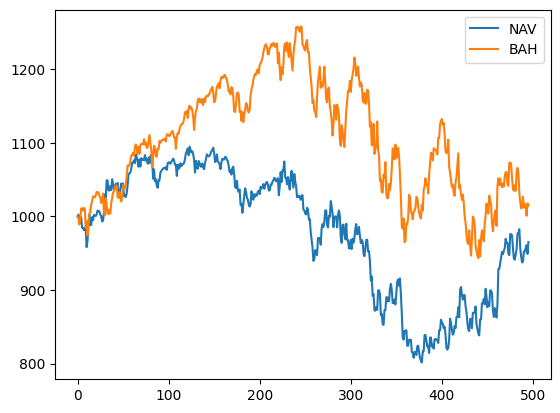

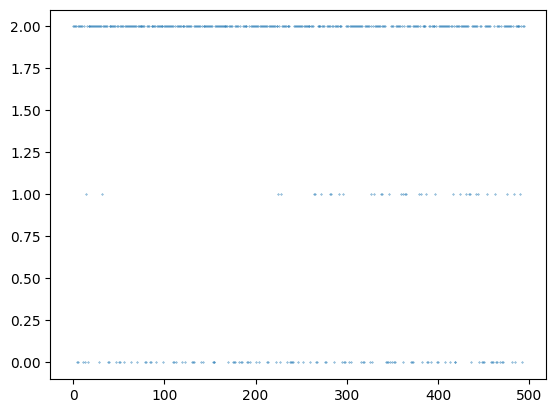

0.9500000000000002
0.9000000000000004
0.8500000000000005
0.8000000000000007
0.7500000000000009
0.7000000000000011
0.6500000000000012
0.6000000000000014
0.5500000000000016
0.5000000000000018
episode:10


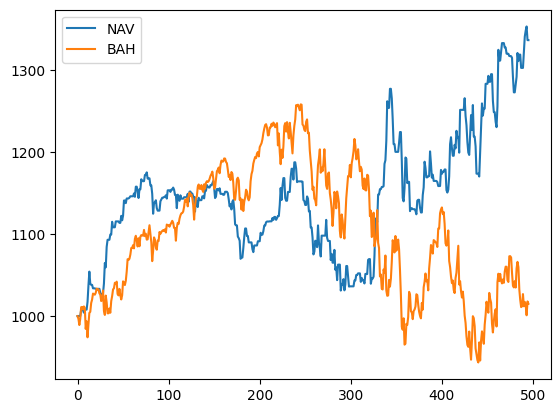

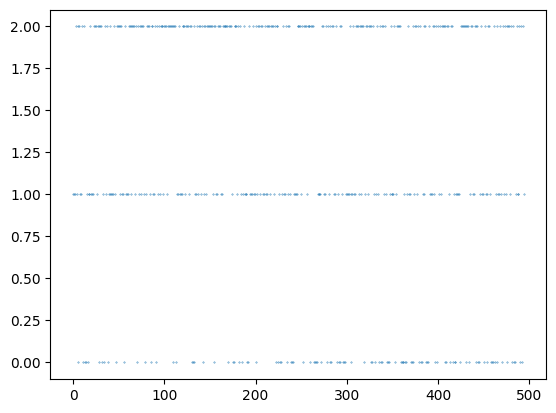

0.45000000000000195
0.40000000000000213
0.3500000000000023
0.3000000000000025
0.25000000000000266
0.20000000000000284
0.15000000000000302
0.1000000000000032
0.050000000000003375
3.520024983300063e-15
episode:20


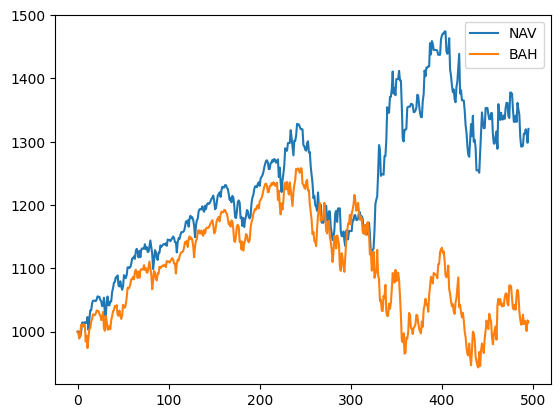

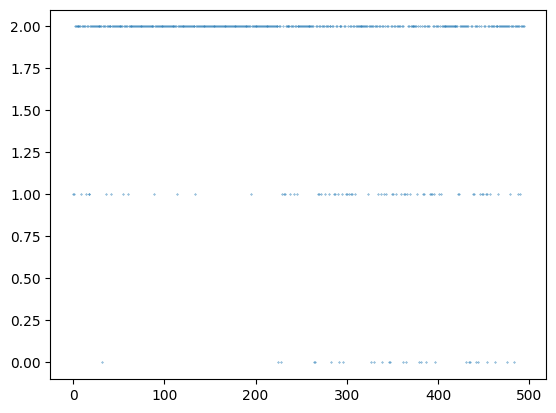

0
0
0
0
0
0
0
0
0
0
episode:30


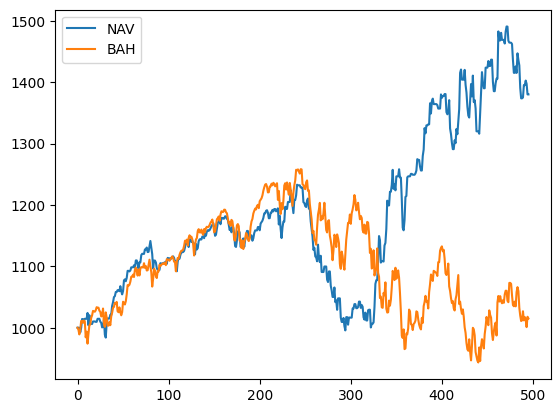

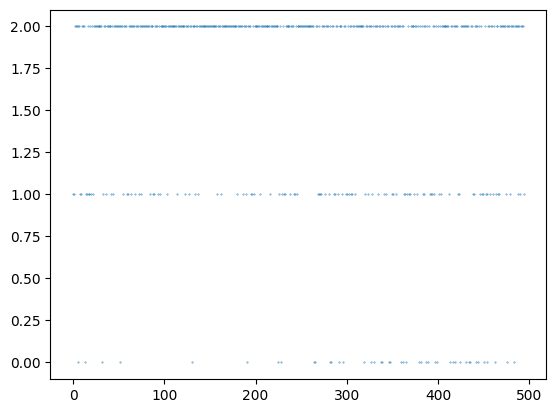

0
0
0
0
0
0
0
0
0
0
episode:40


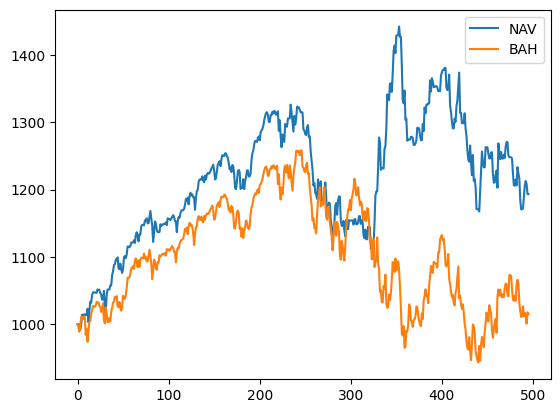

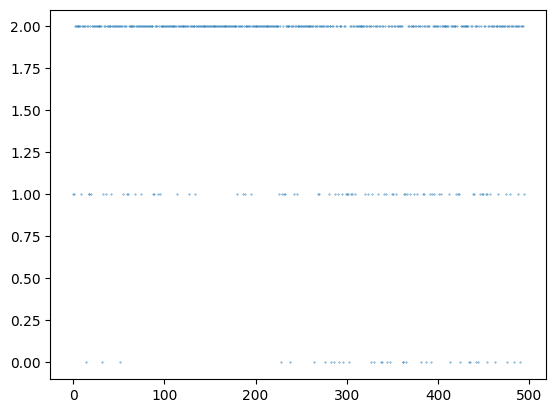

0
0
0
0
0
0
0
0
0
0
episode:50


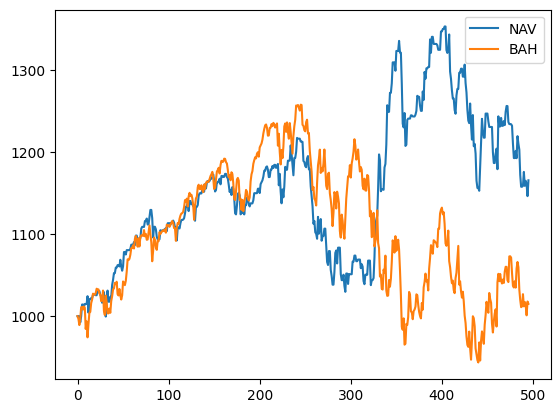

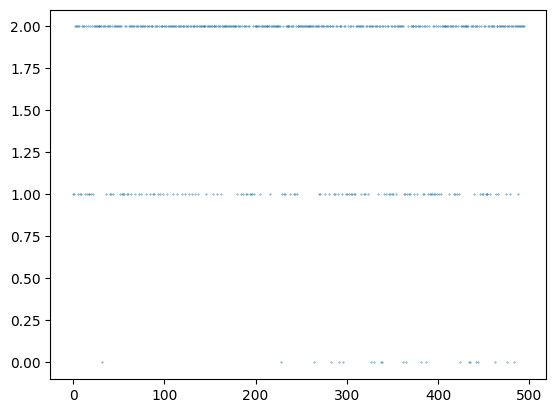

0
0
0
0
0
0
0
0
0
0
episode:60


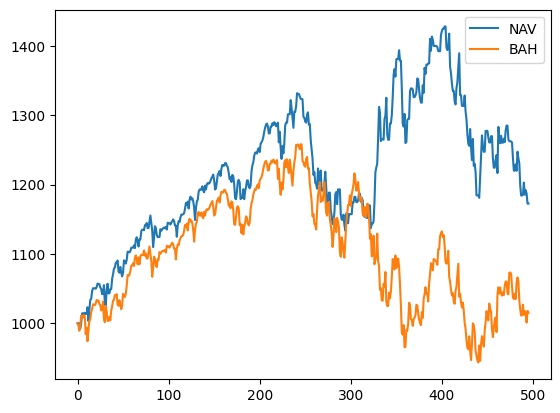

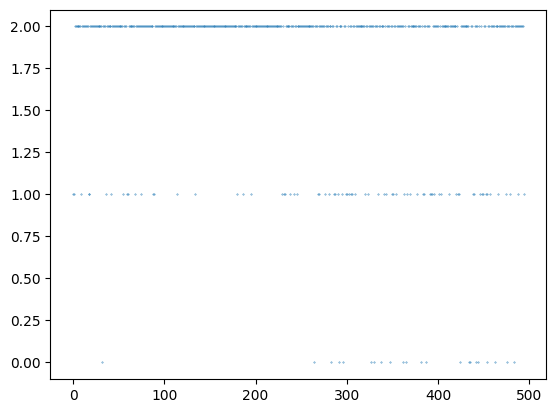

0
0
0
0
0
0
0
0
0
0
episode:70


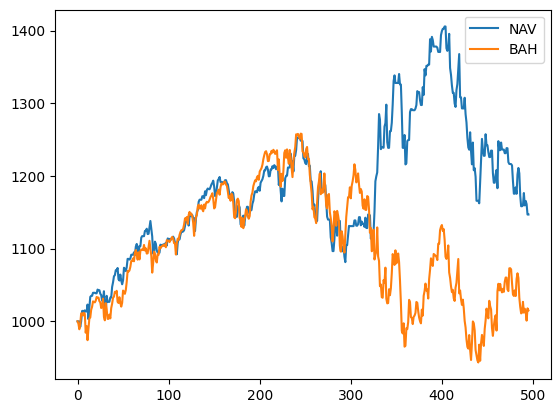

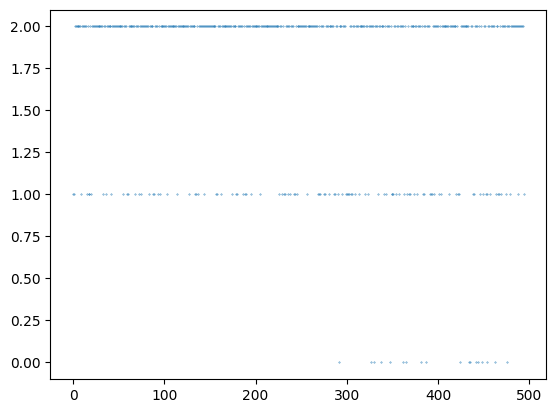

0
0
0
0
0
0
0
0
0
0
episode:80


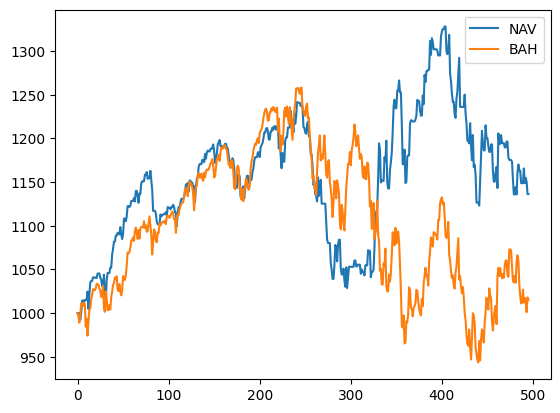

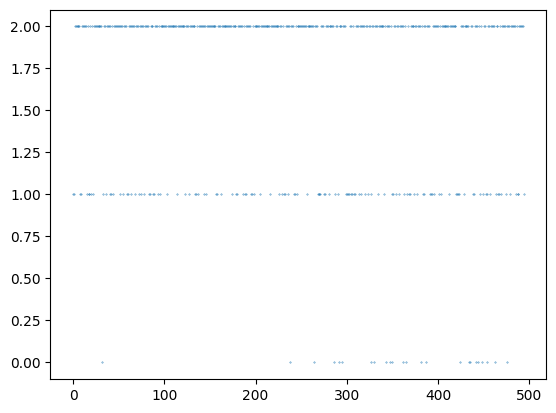

0
0
0
0
0
0
0
0
0
0
episode:90


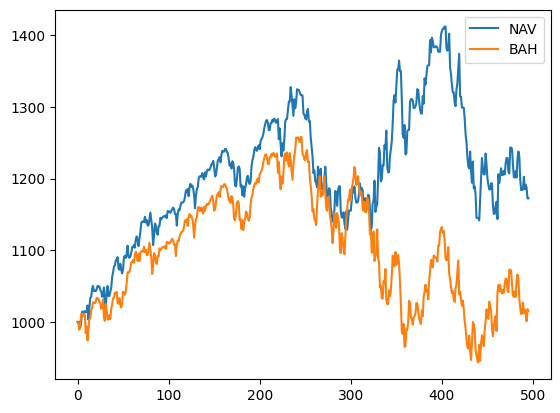

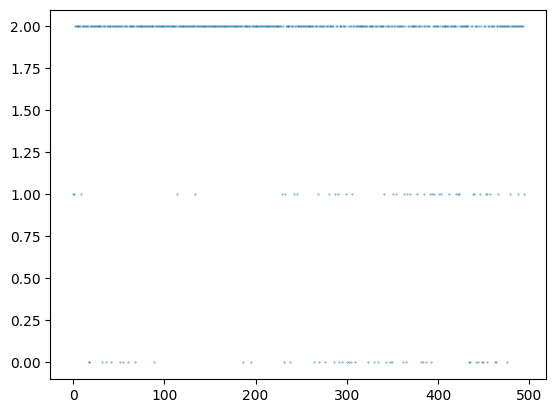

0
0
0
0
0
0
0
0
0


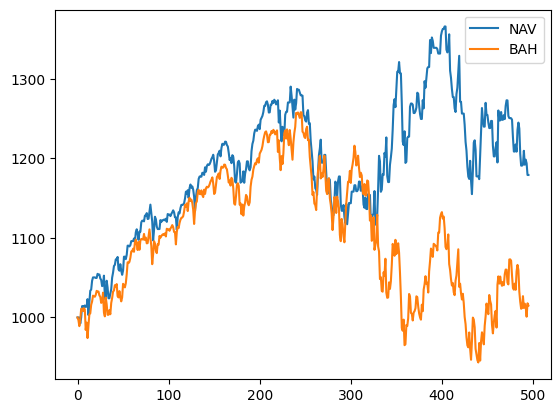

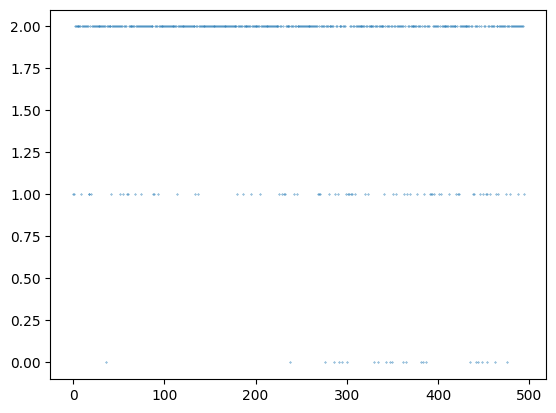

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.0.pth
current penalty factor:1.1
0
episode:0


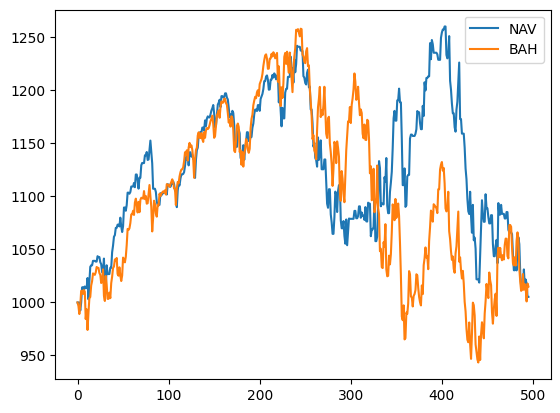

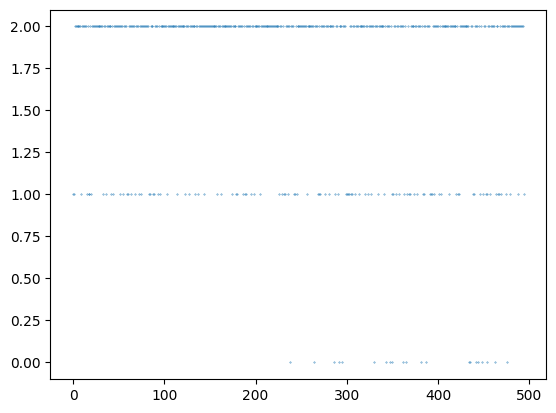

0
0
0
0
0
0
0
0
0
0
episode:10


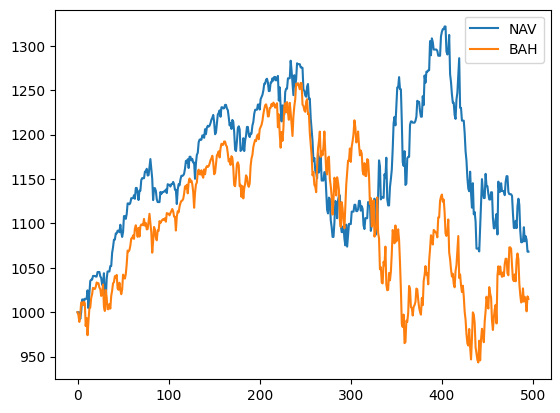

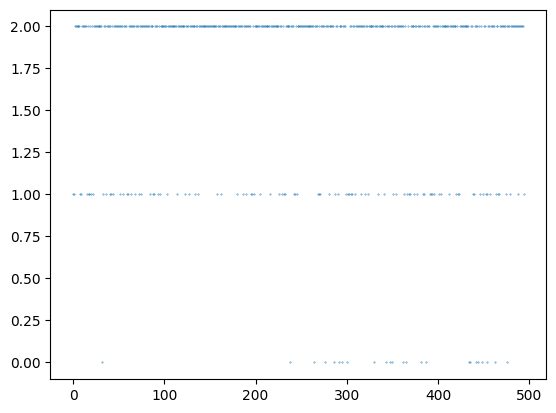

0
0
0
0
0
0
0
0
0
0
episode:20


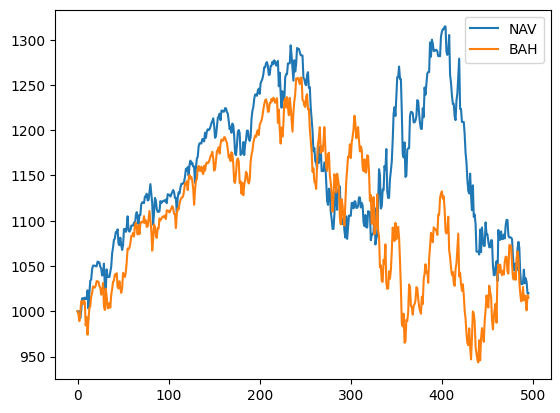

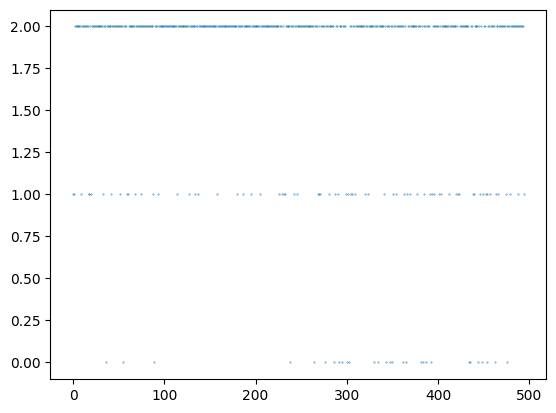

0
0
0
0
0
0
0
0
0
0
episode:30


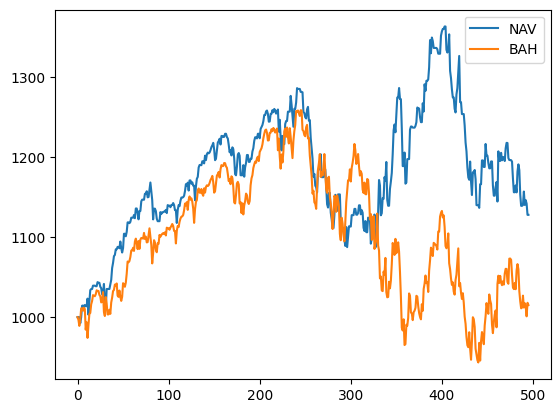

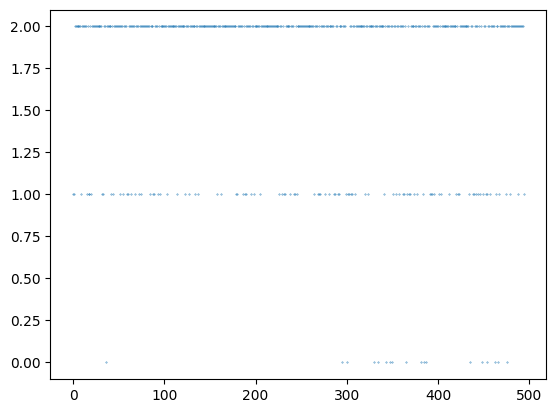

0
0
0
0
0
0
0
0
0
0
episode:40


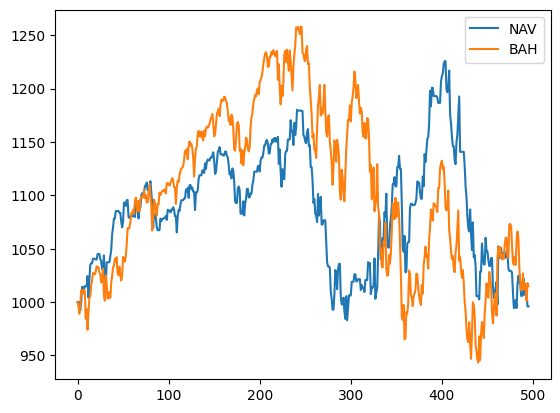

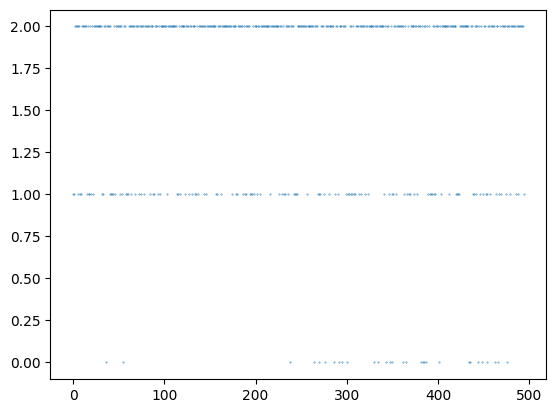

0
0
0
0
0
0
0
0
0
0
episode:50


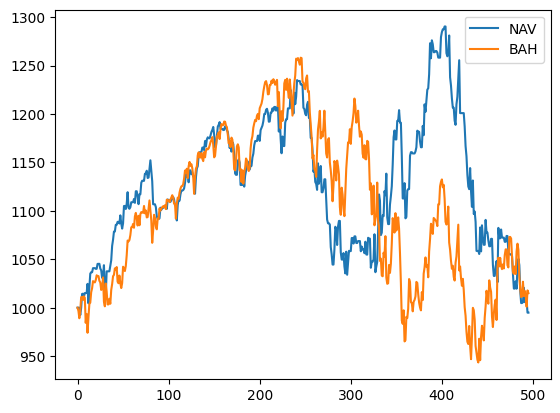

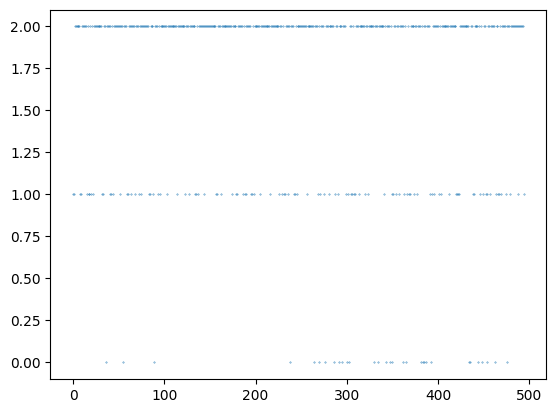

0
0
0
0
0
0
0
0
0
0
episode:60


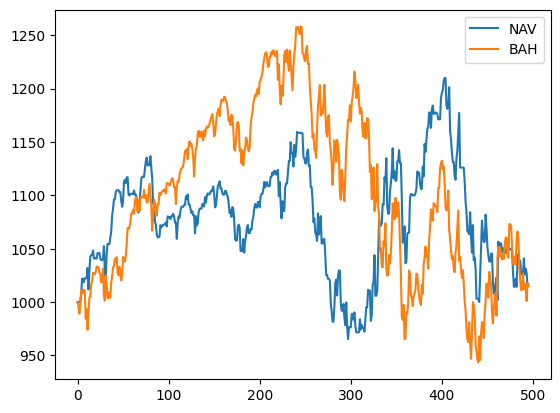

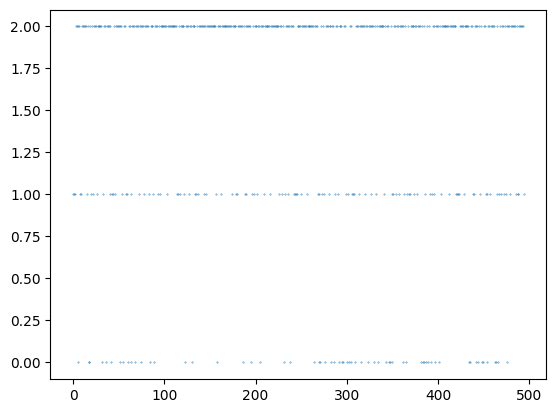

0
0
0
0
0
0
0
0
0
0
episode:70


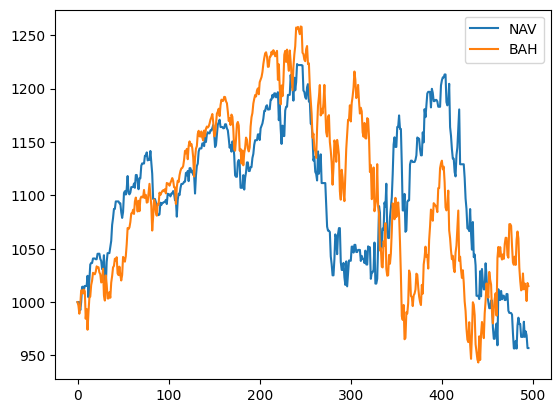

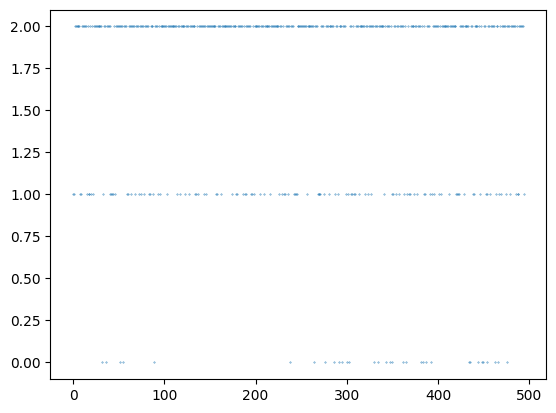

0
0
0
0
0
0
0
0
0
0
episode:80


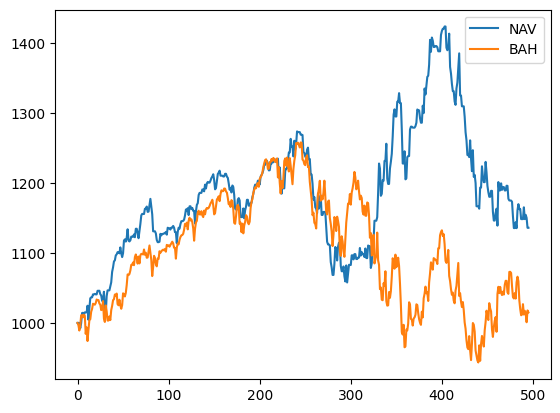

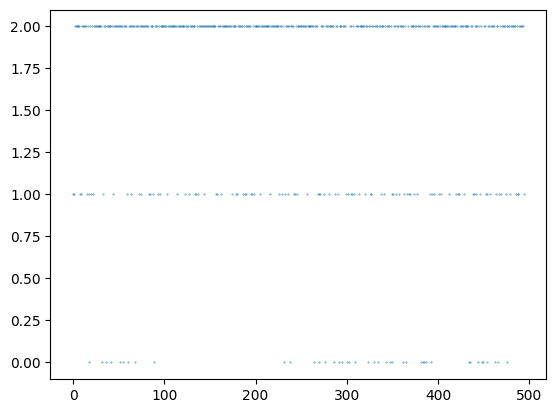

0
0
0
0
0
0
0
0
0
0
episode:90


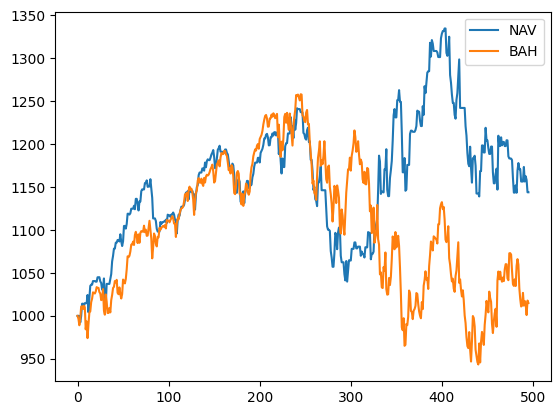

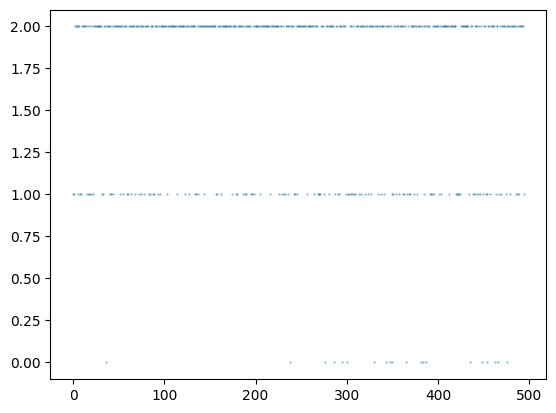

0
0
0
0
0
0
0
0
0


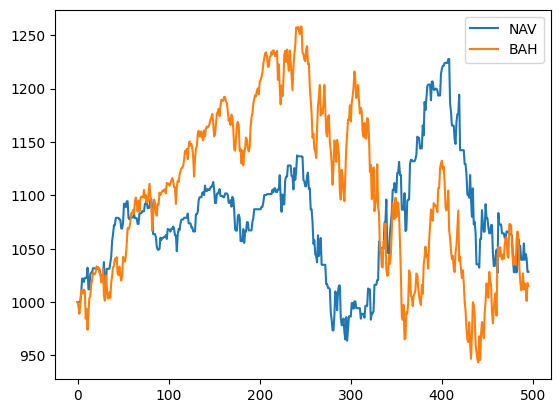

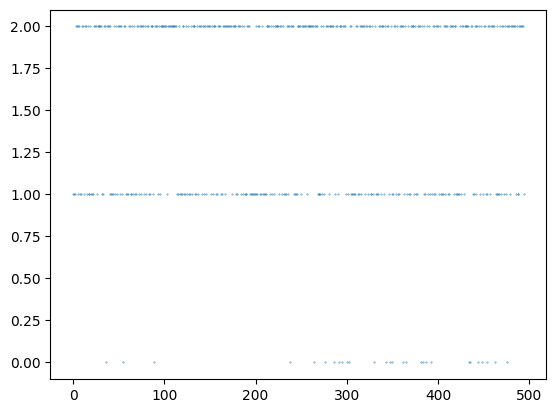

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.1.pth
current penalty factor:1.2
0
episode:0


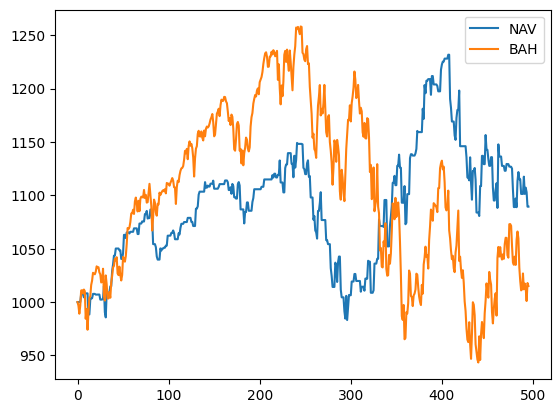

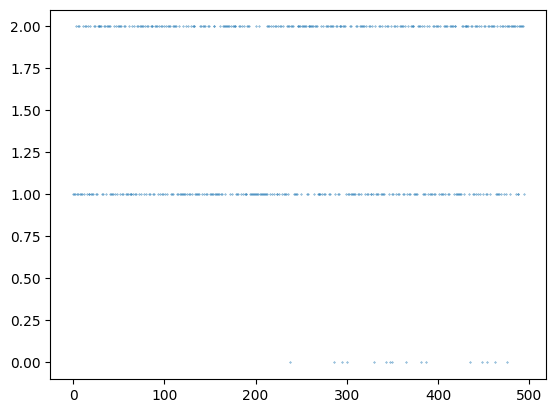

0
0
0
0
0
0
0
0
0
0
episode:10


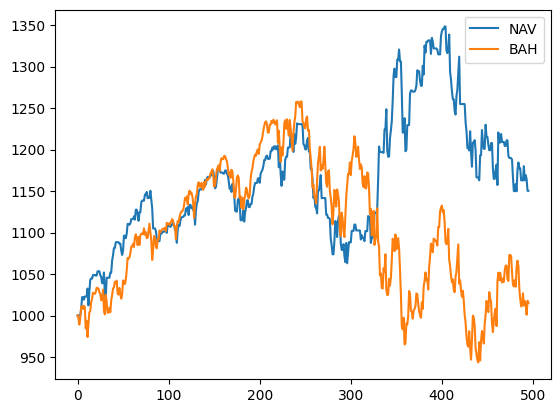

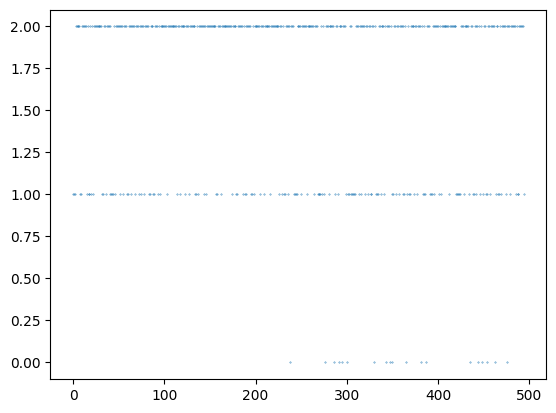

0
0
0
0
0
0
0
0
0
0
episode:20


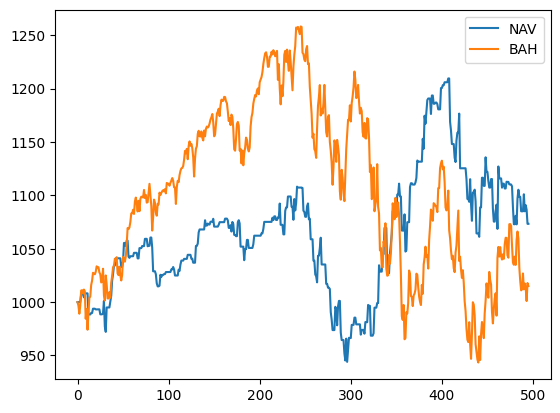

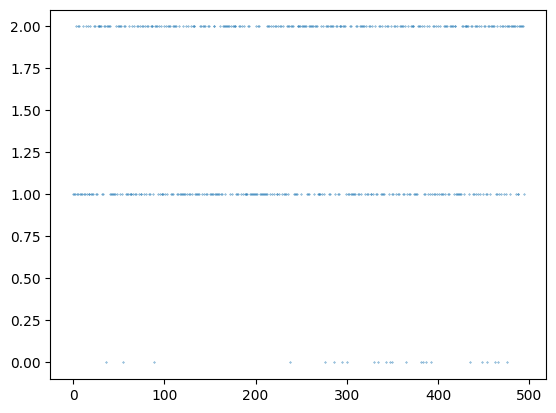

0
0
0
0
0
0
0
0
0
0
episode:30


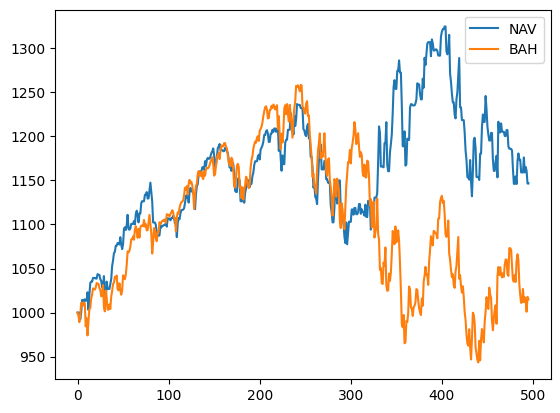

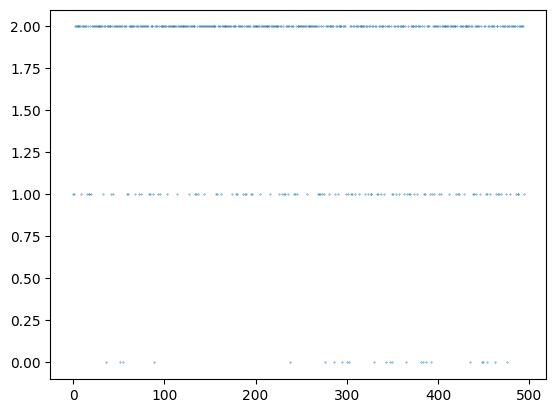

0
0
0
0
0
0
0
0
0
0
episode:40


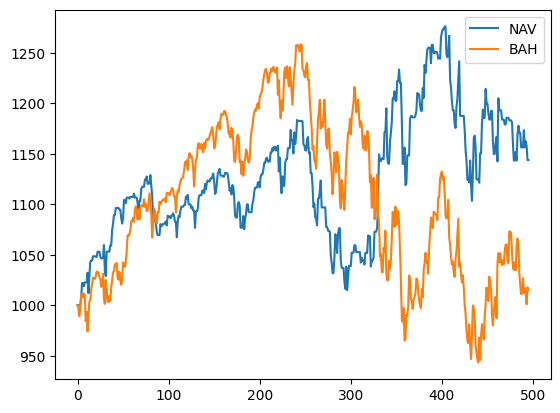

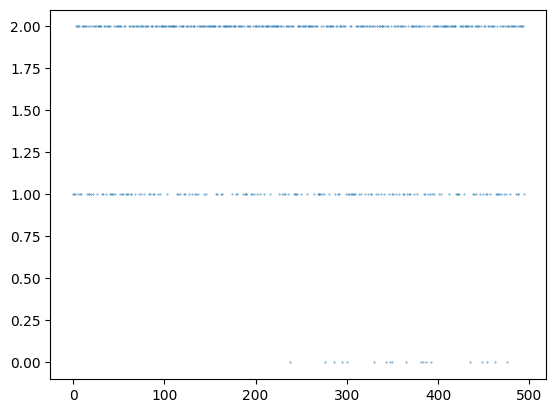

0
0
0
0
0
0
0
0
0
0
episode:50


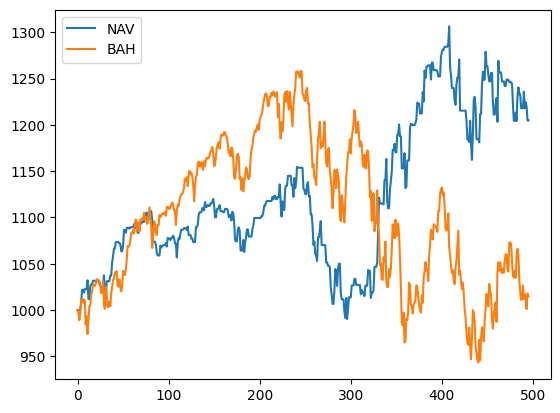

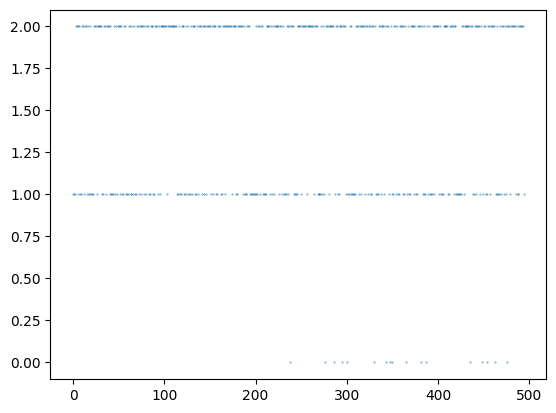

0
0
0
0
0
0
0
0
0
0
episode:60


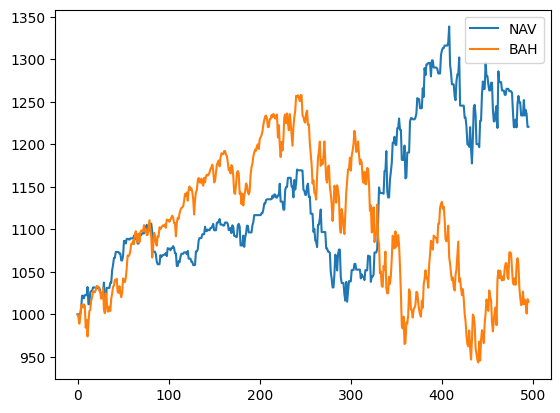

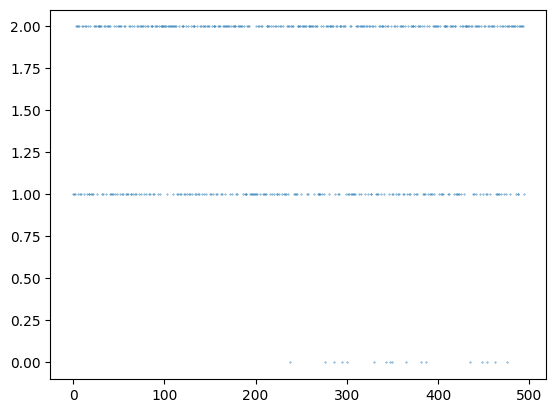

0
0
0
0
0
0
0
0
0
0
episode:70


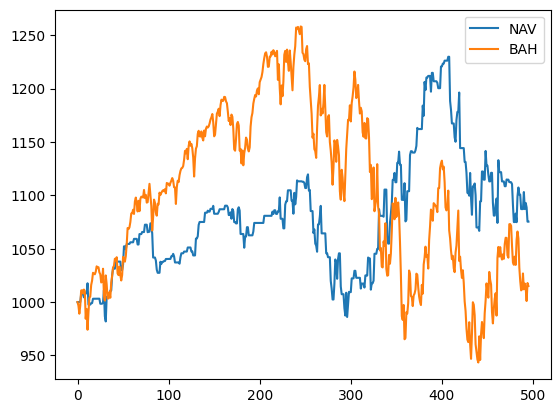

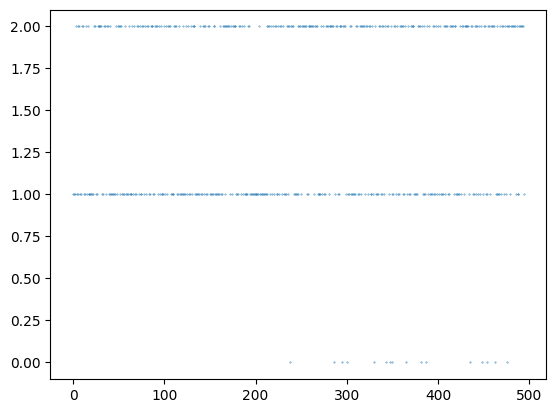

0
0
0
0
0
0
0
0
0
0
episode:80


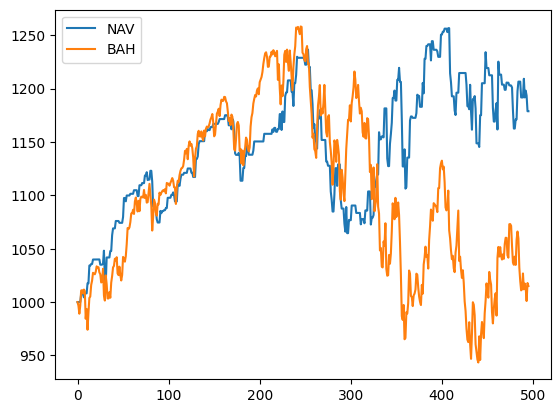

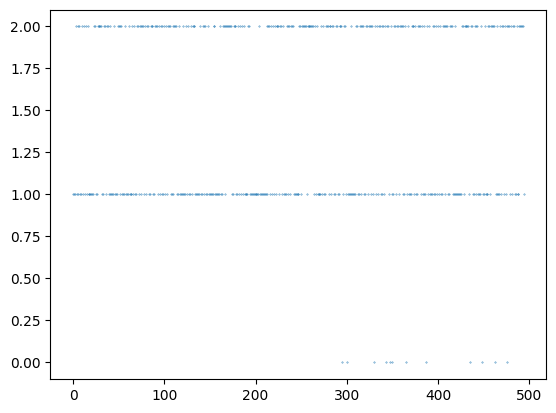

0
0
0
0
0
0
0
0
0
0
episode:90


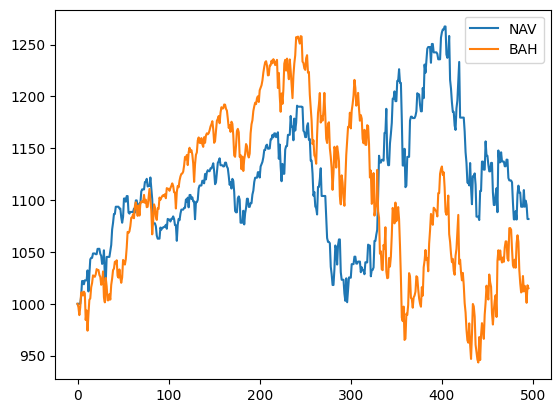

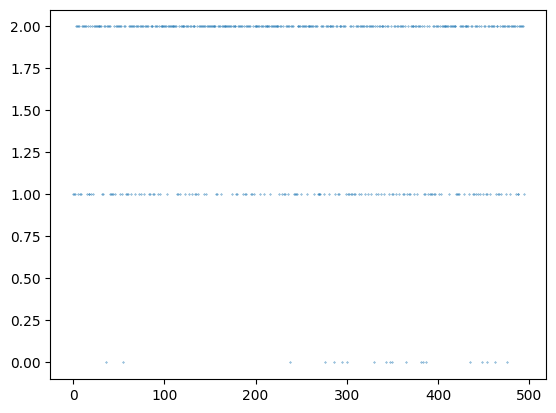

0
0
0
0
0
0
0
0
0


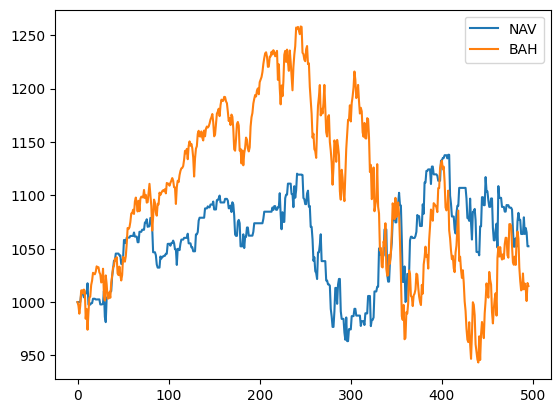

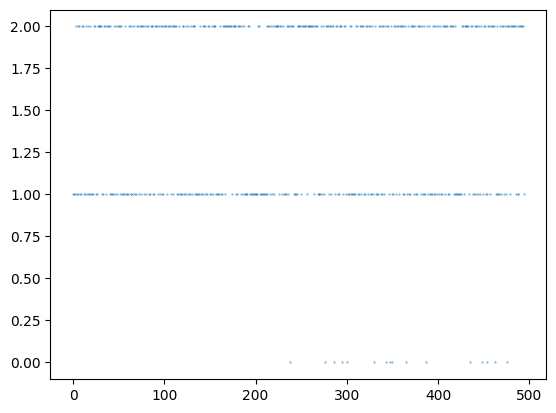

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.2.pth
current penalty factor:1.3
0
episode:0


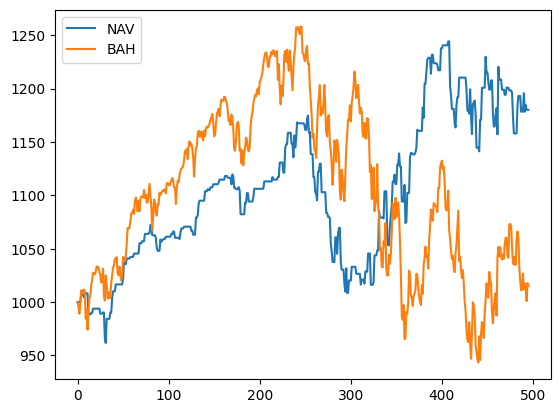

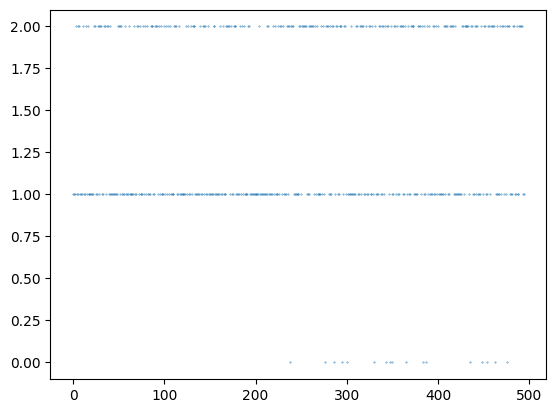

0
0
0
0
0
0
0
0
0
0
episode:10


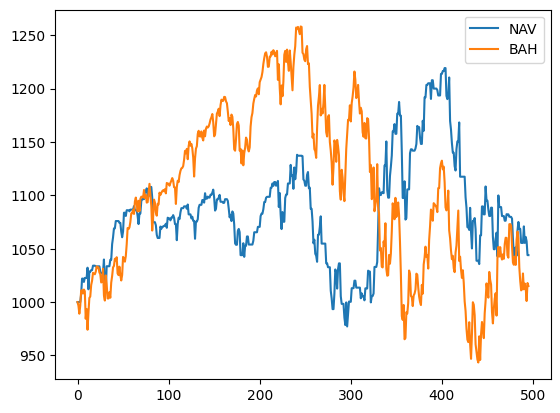

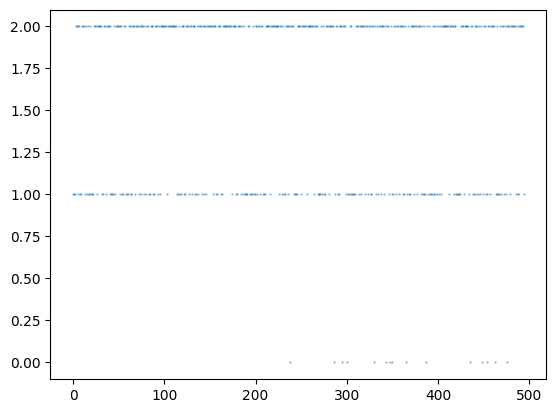

0
0
0
0
0
0
0
0
0
0
episode:20


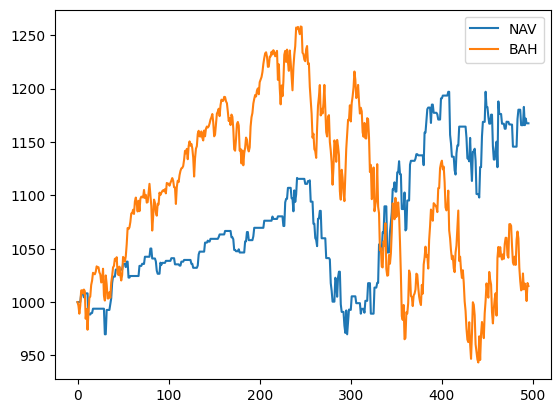

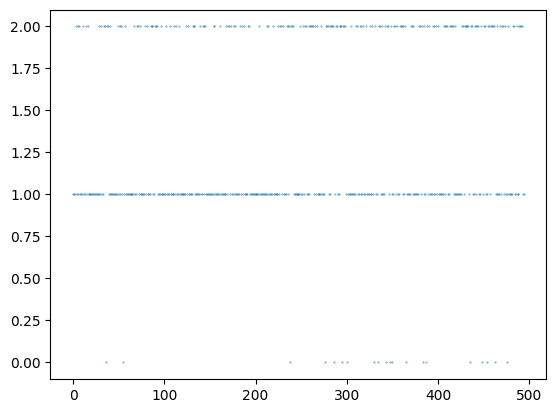

0
0
0
0
0
0
0
0
0
0
episode:30


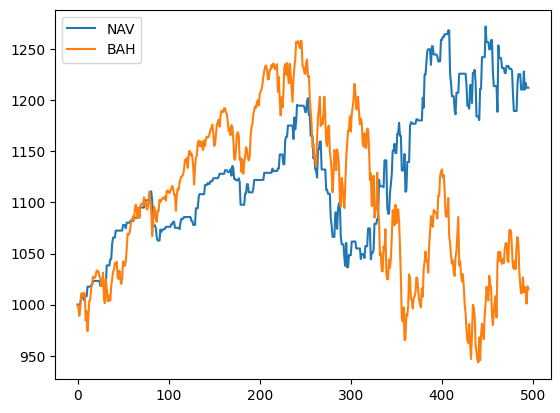

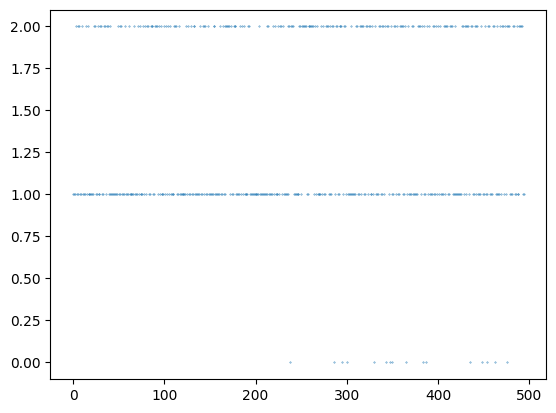

0
0
0
0
0
0
0
0
0
0
episode:40


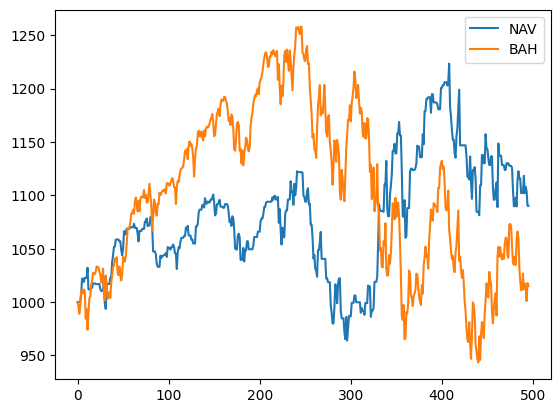

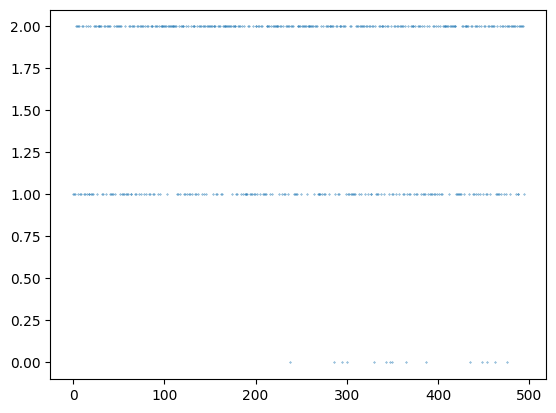

0
0
0
0
0
0
0
0
0
0
episode:50


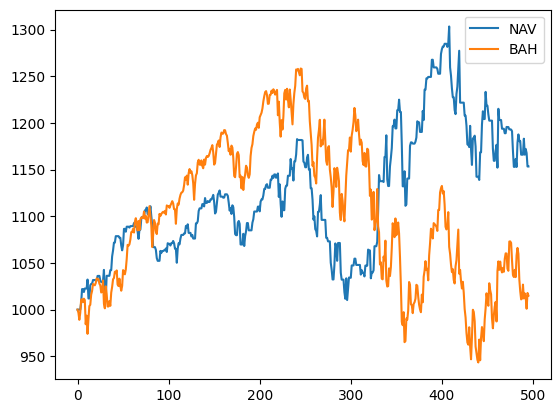

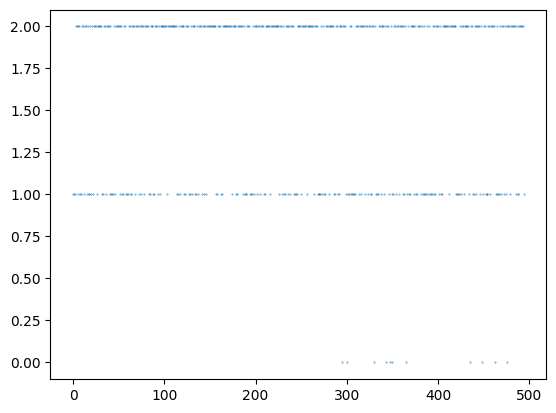

0
0
0
0
0
0
0
0
0
0
episode:60


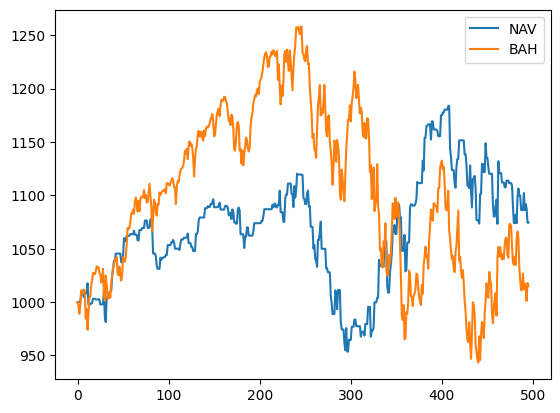

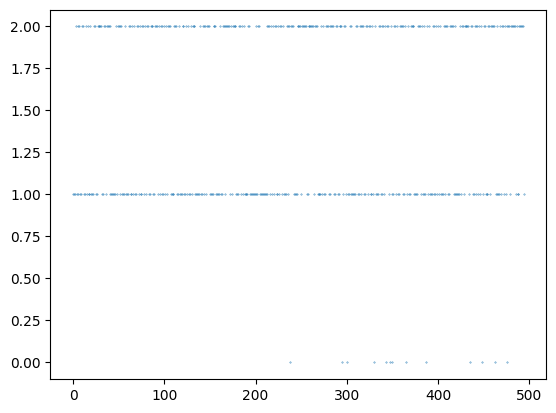

0
0
0
0
0
0
0
0
0
0
episode:70


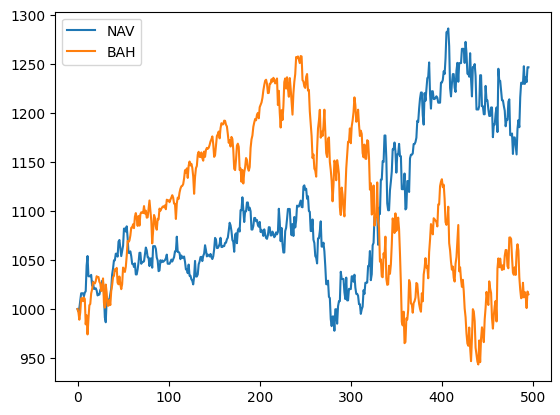

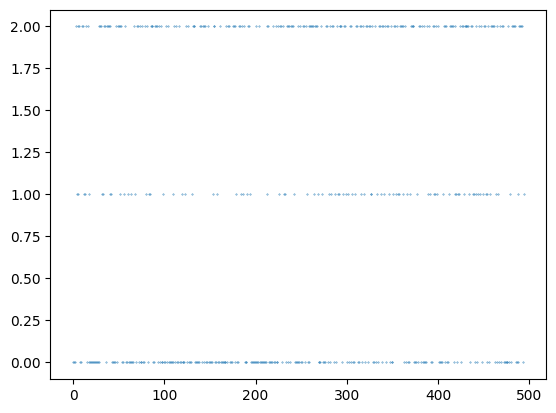

0
0
0
0
0
0
0
0
0
0
episode:80


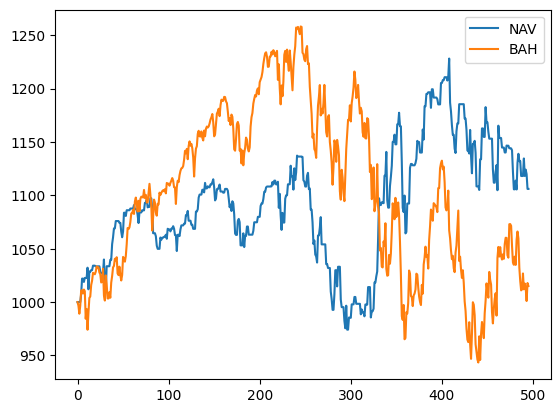

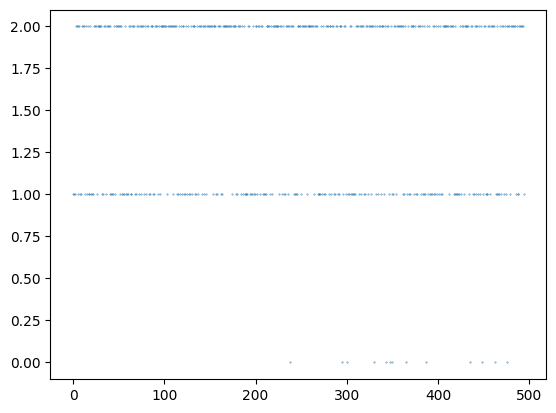

0
0
0
0
0
0
0
0
0
0
episode:90


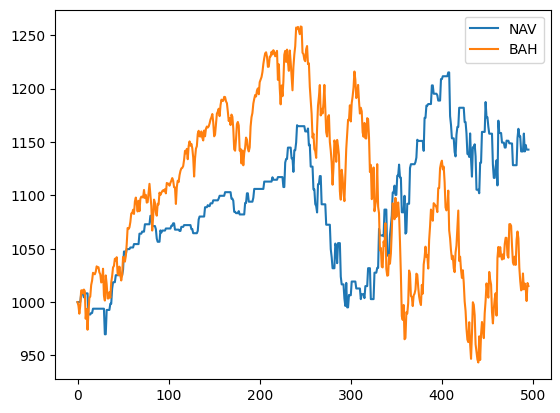

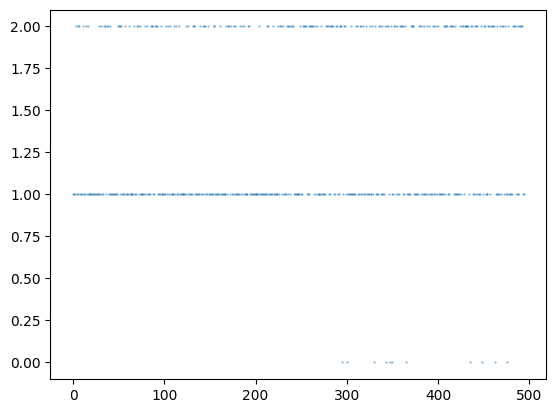

0
0
0
0
0
0
0
0
0


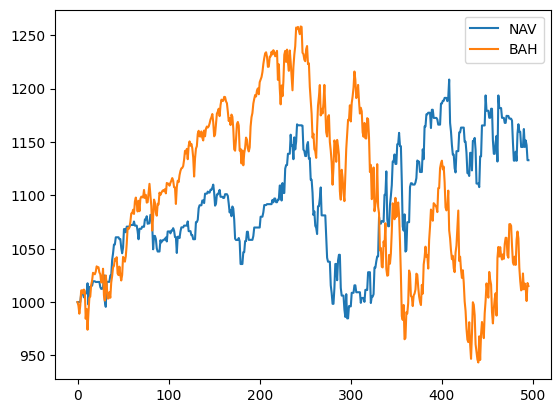

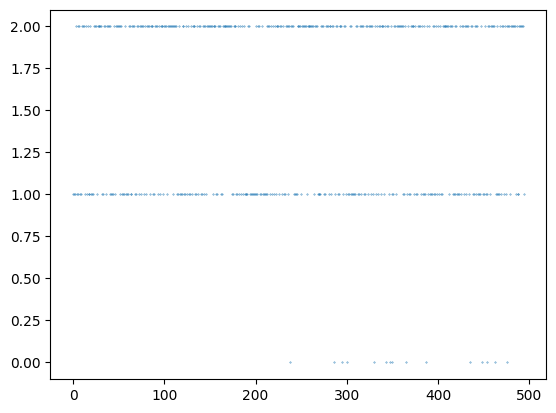

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.3.pth
current penalty factor:1.4
0
episode:0


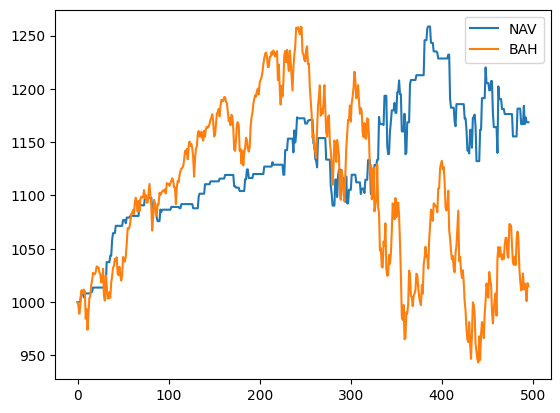

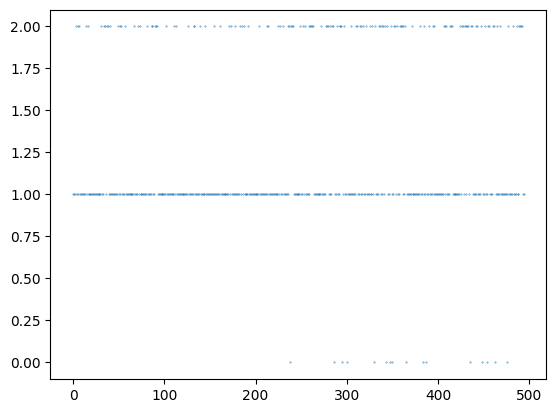

0
0
0
0
0
0
0
0
0
0
episode:10


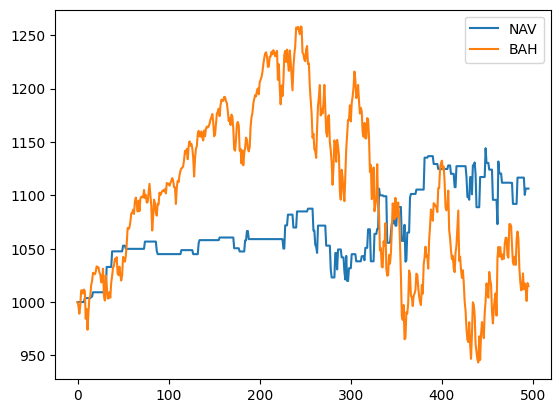

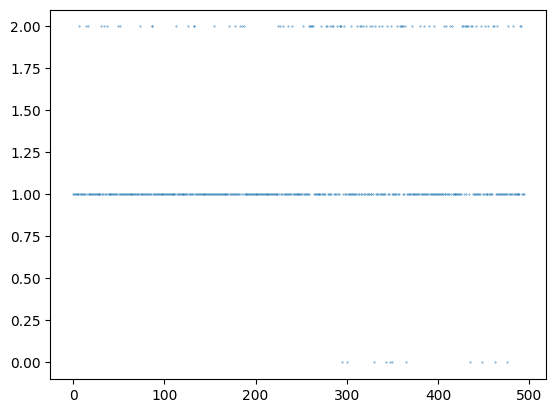

0
0
0
0
0
0
0
0
0
0
episode:20


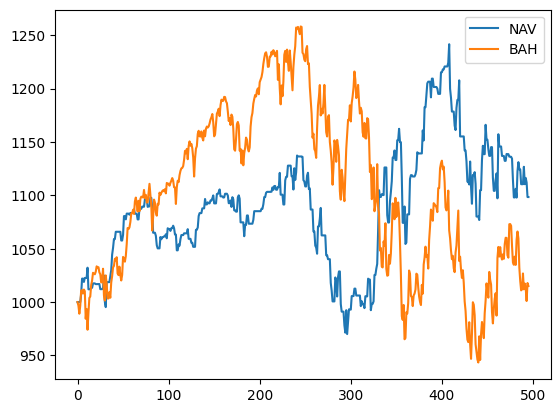

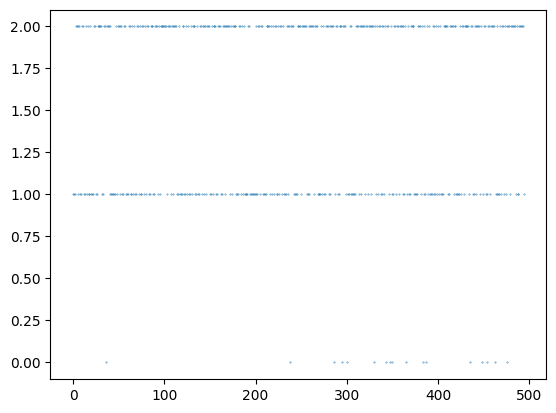

0
0
0
0
0
0
0
0
0
0
episode:30


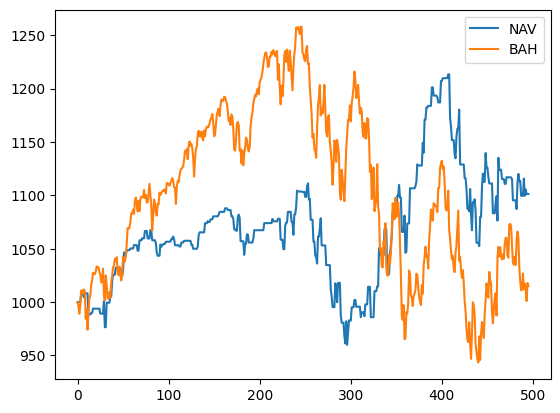

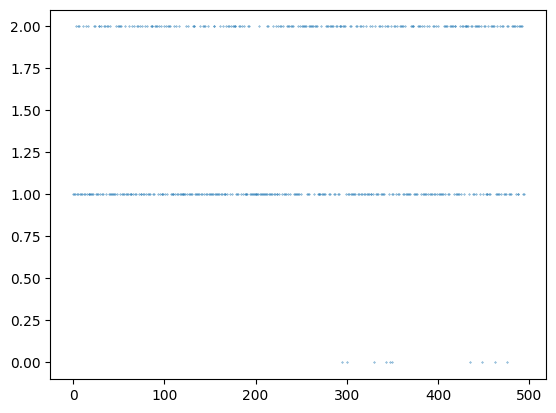

0
0
0
0
0
0
0
0
0
0
episode:40


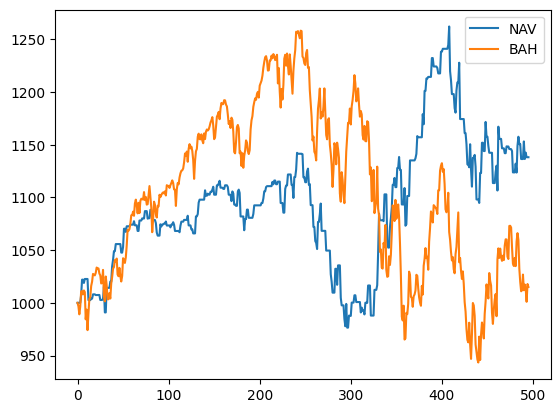

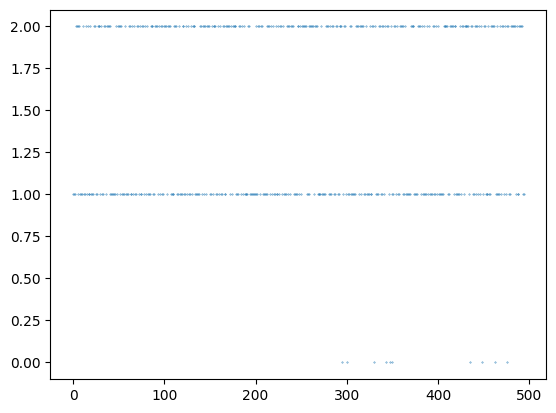

0
0
0
0
0
0
0
0
0
0
episode:50


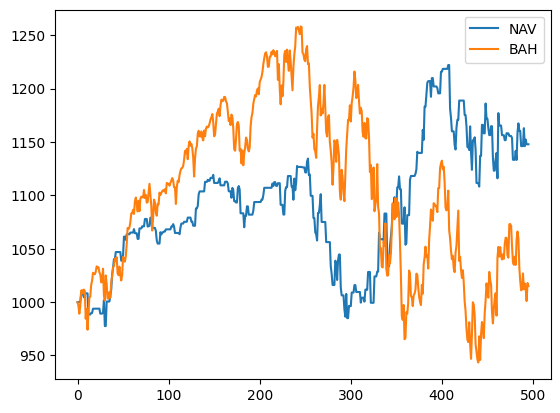

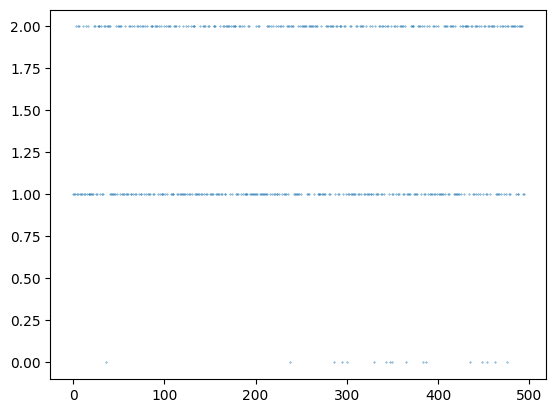

0
0
0
0
0
0
0
0
0
0
episode:60


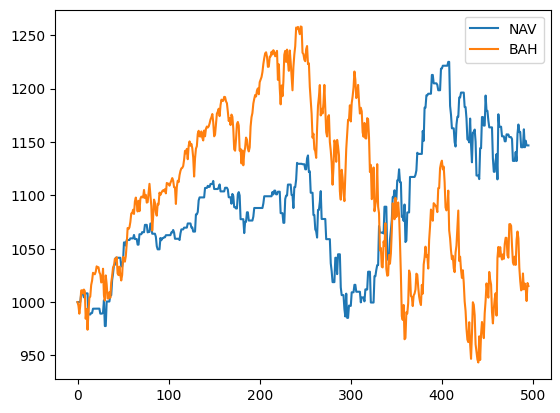

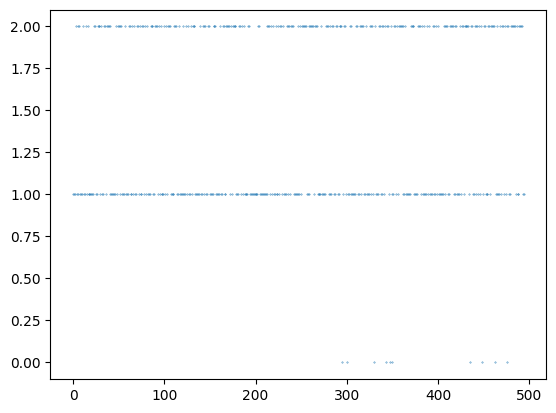

0
0
0
0
0
0
0
0
0
0
episode:70


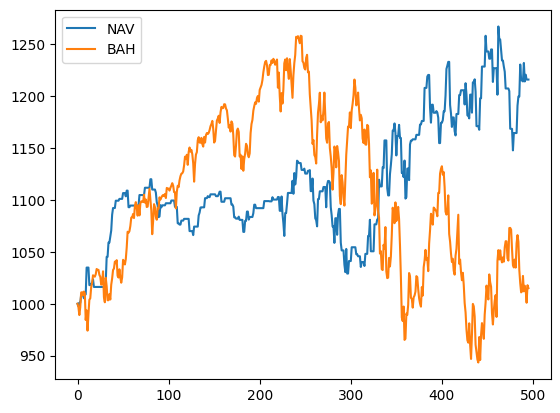

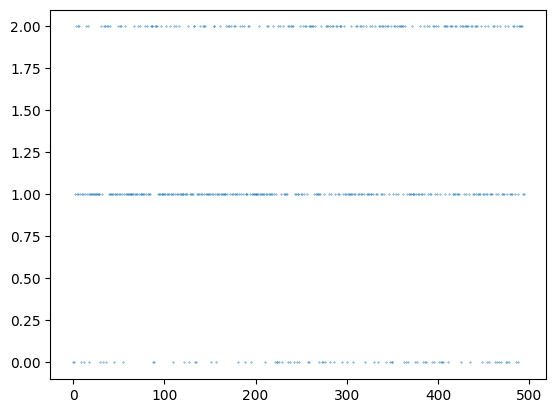

0
0
0
0
0
0
0
0
0
0
episode:80


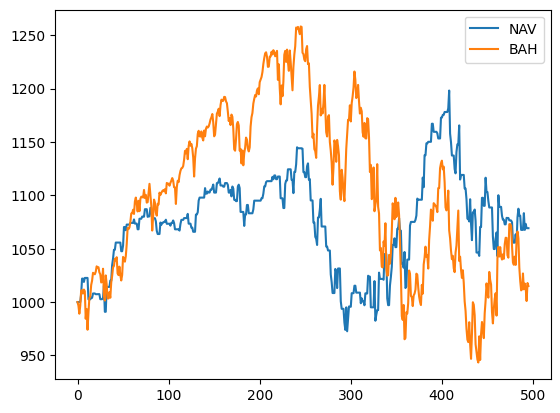

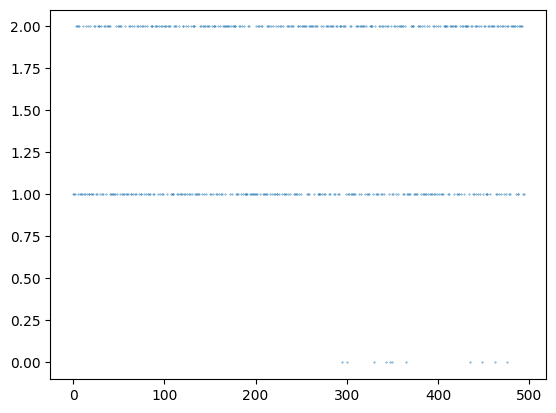

0
0
0
0
0
0
0
0
0
0
episode:90


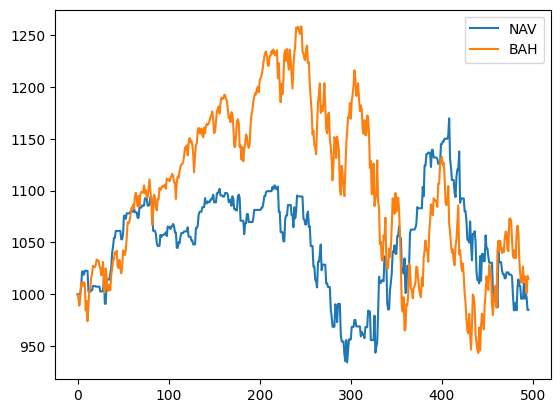

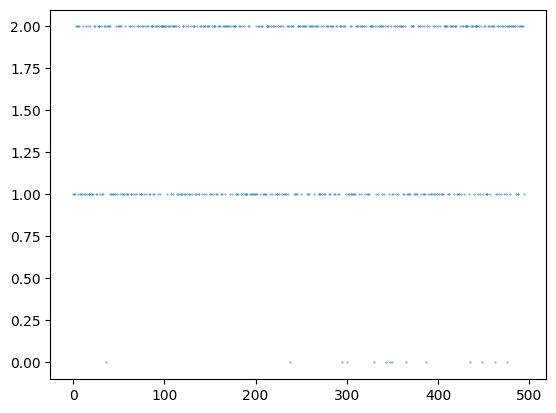

0
0
0
0
0
0
0
0
0


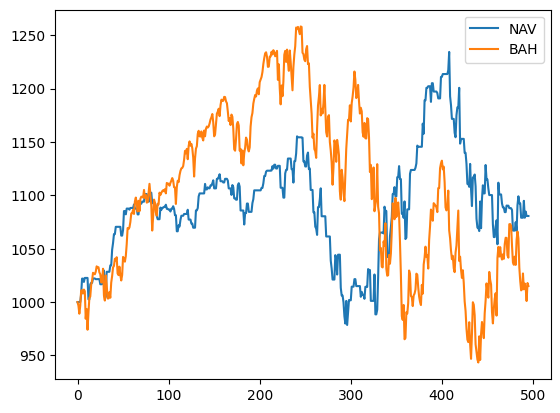

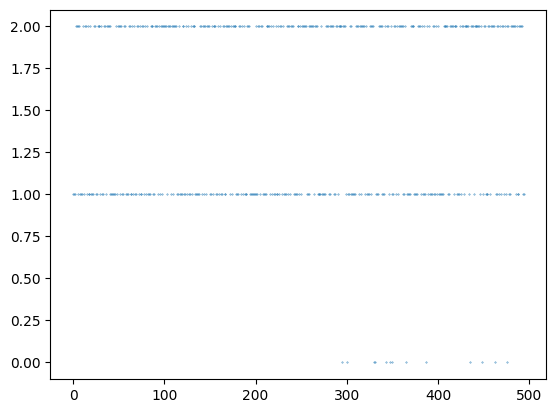

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.4.pth
current penalty factor:1.5
0
episode:0


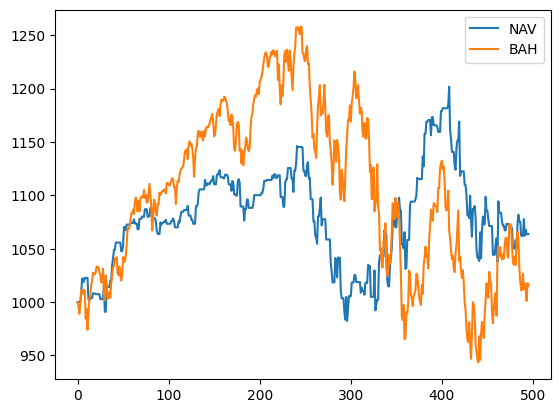

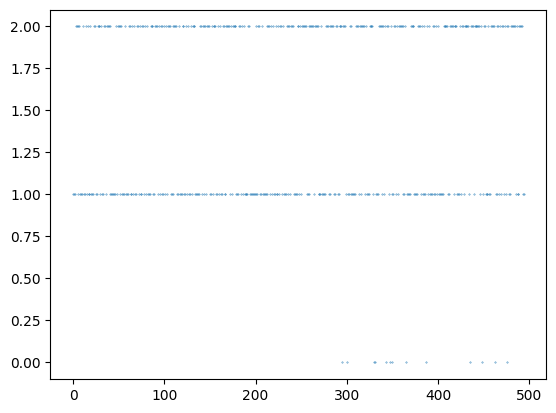

0
0
0
0
0
0
0
0
0
0
episode:10


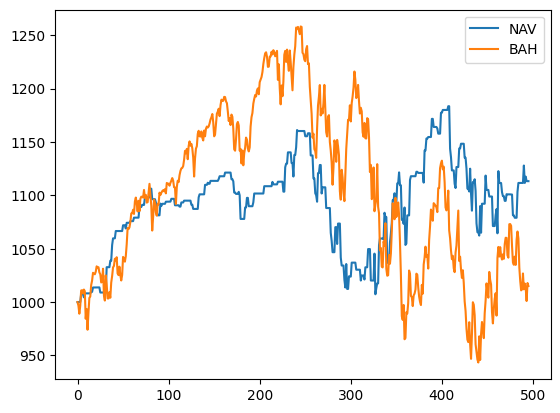

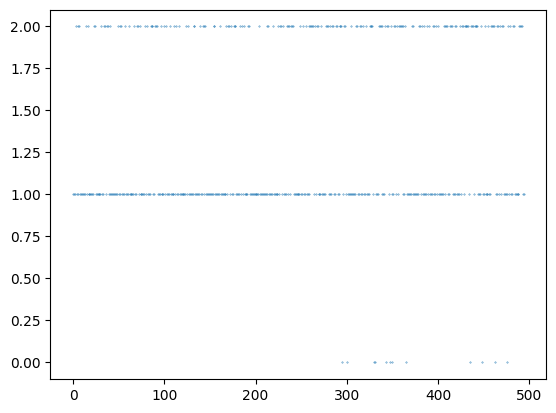

0
0
0
0
0
0
0
0
0
0
episode:20


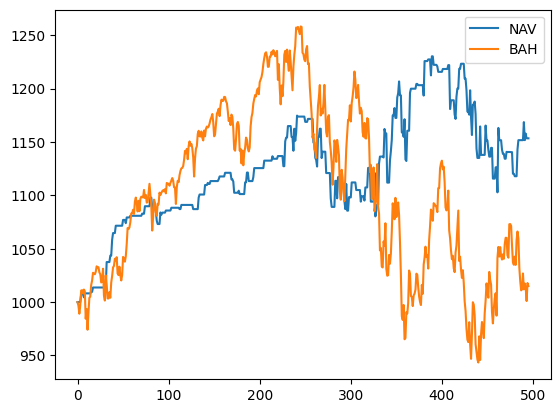

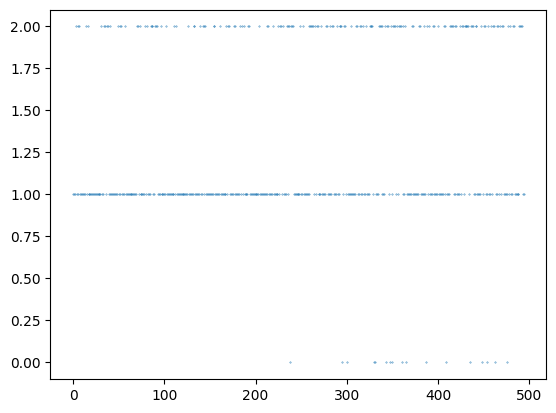

0
0
0
0
0
0
0
0
0
0
episode:30


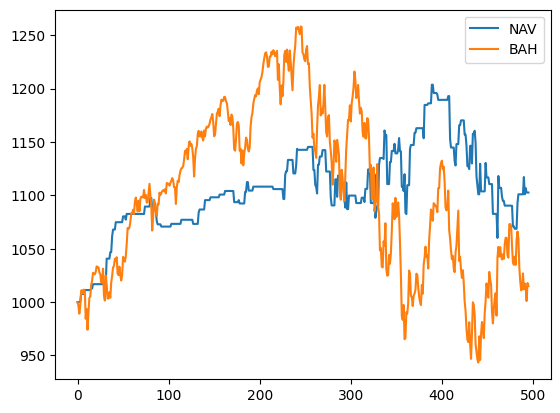

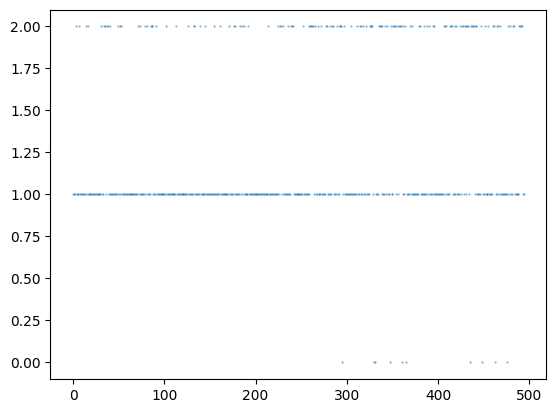

0
0
0
0
0
0
0
0
0
0
episode:40


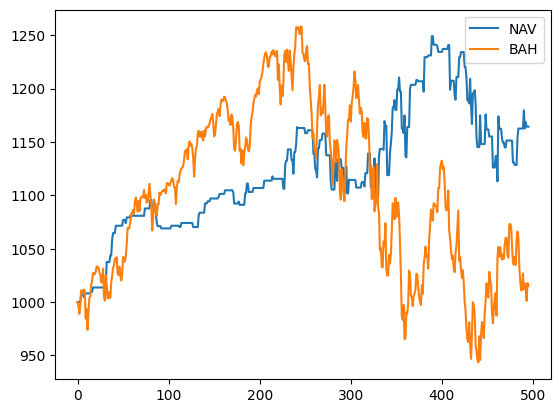

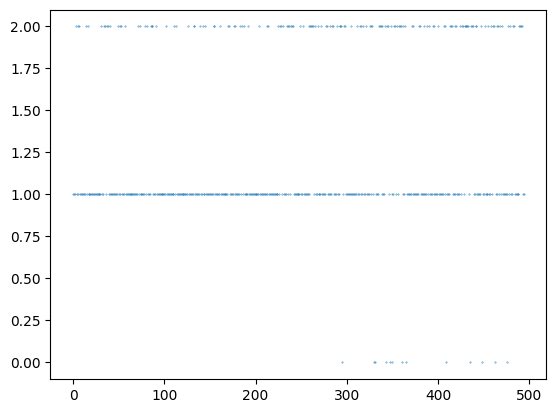

0
0
0
0
0
0
0
0
0
0
episode:50


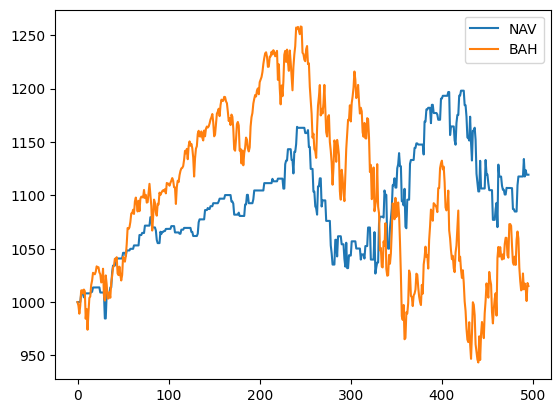

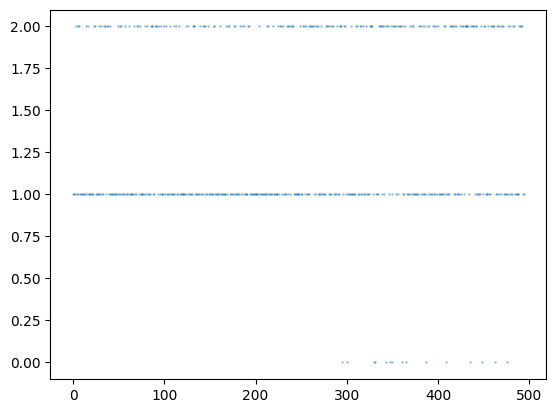

0
0
0
0
0
0
0
0
0
0
episode:60


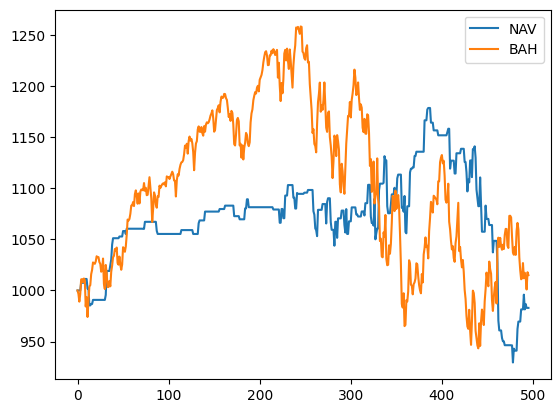

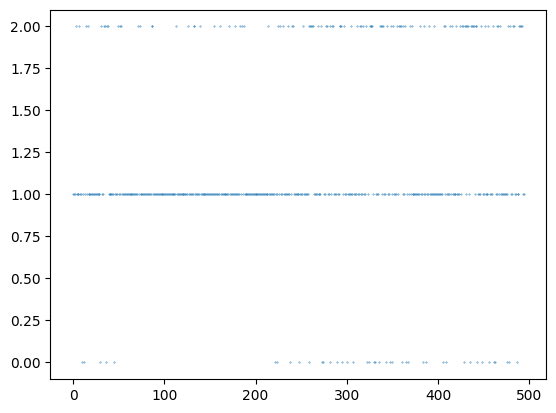

0
0
0
0
0
0
0
0
0
0
episode:70


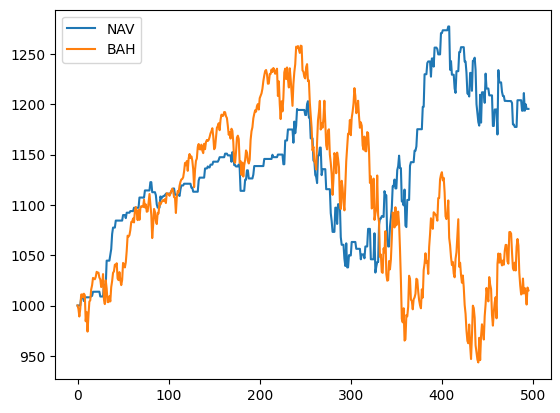

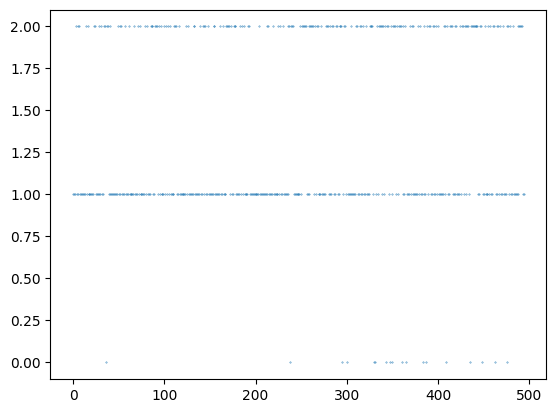

0
0
0
0
0
0
0
0
0
0
episode:80


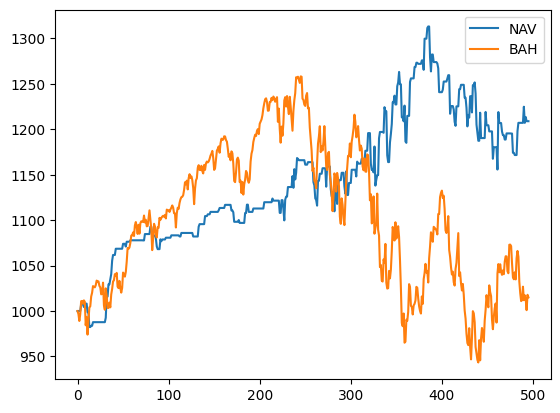

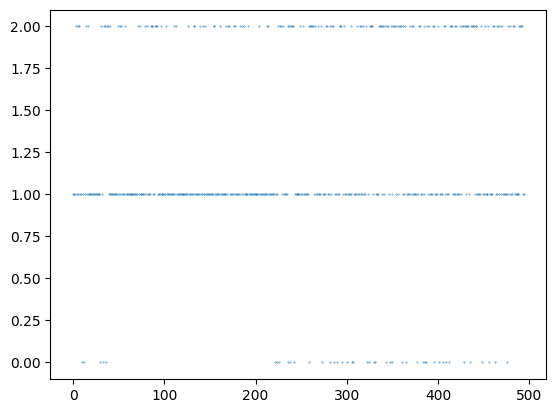

0
0
0
0
0
0
0
0
0
0
episode:90


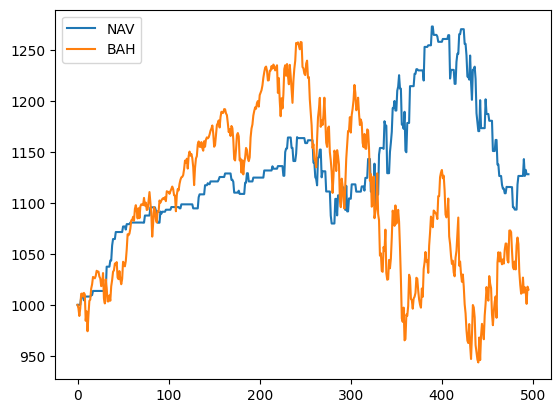

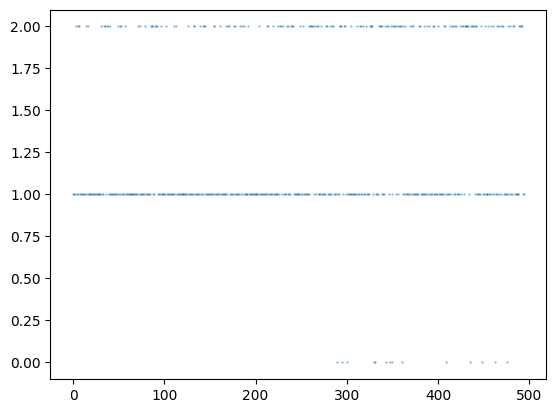

0
0
0
0
0
0
0
0
0


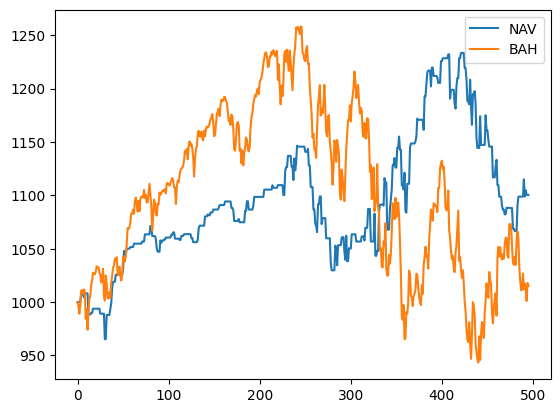

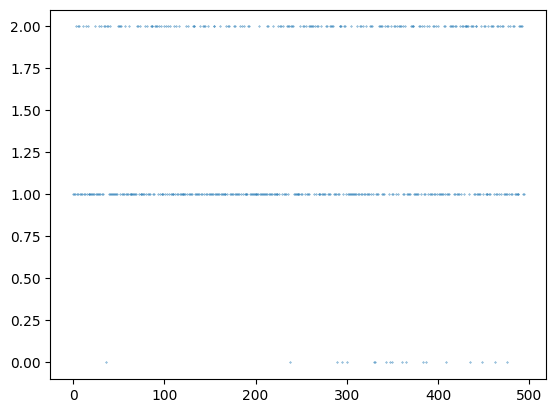

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.5.pth
current penalty factor:1.6
0
episode:0


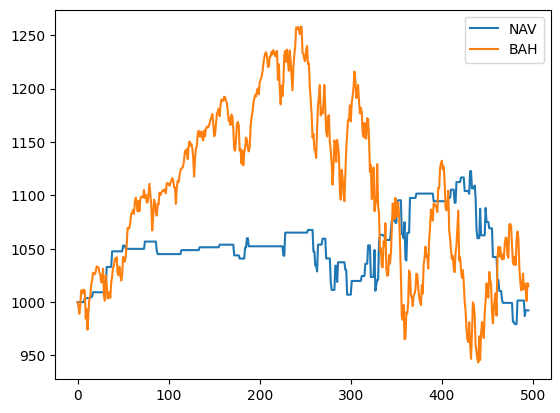

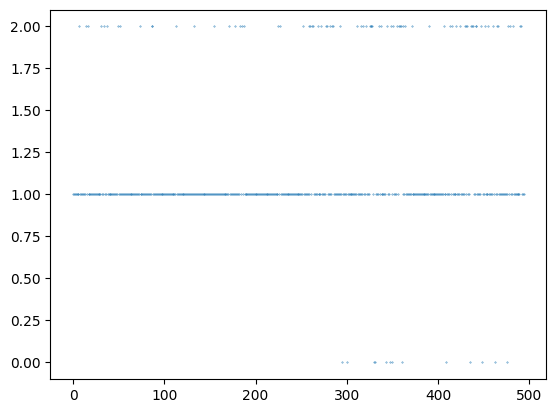

0
0
0
0
0
0
0
0
0
0
episode:10


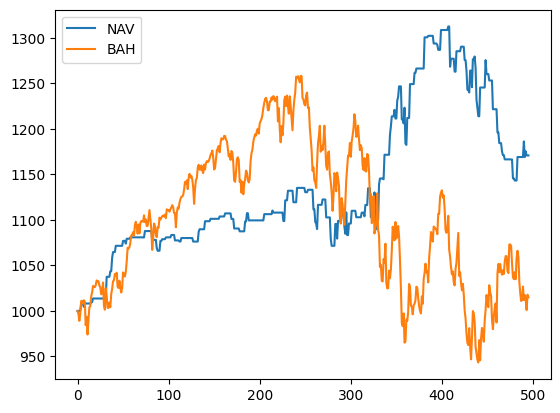

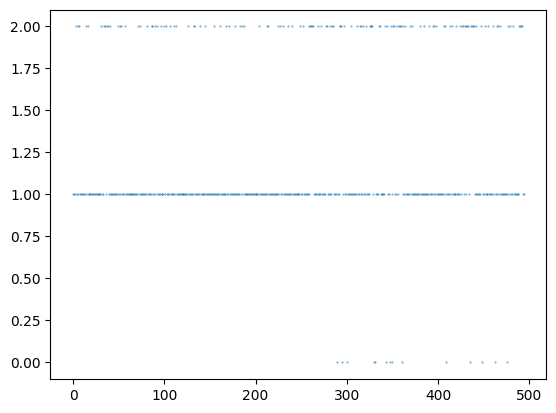

0
0
0
0
0
0
0
0
0
0
episode:20


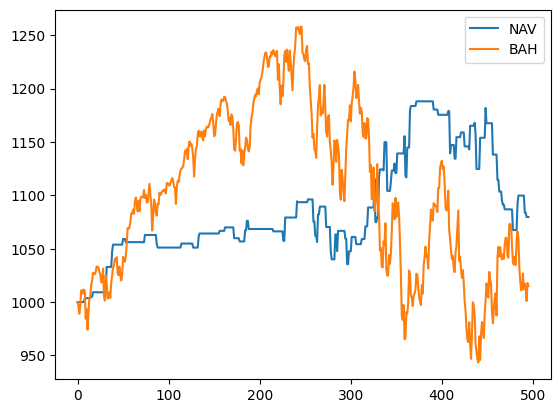

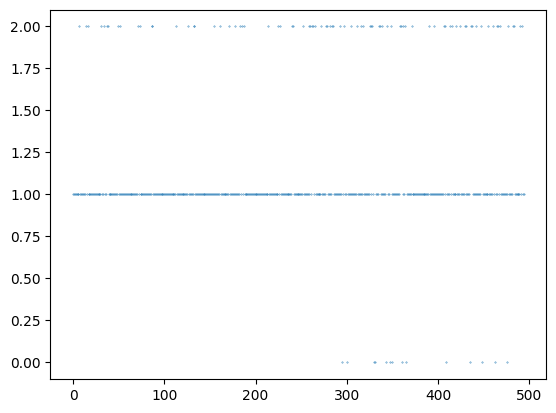

0
0
0
0
0
0
0
0
0
0
episode:30


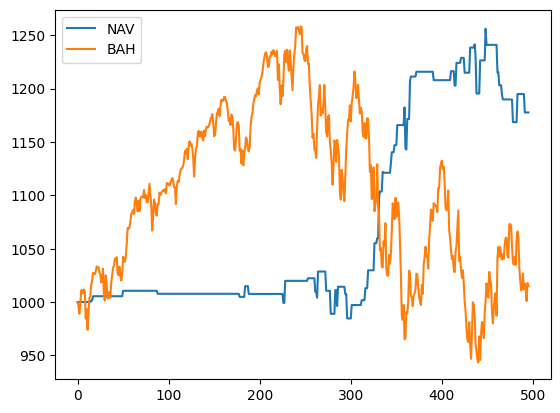

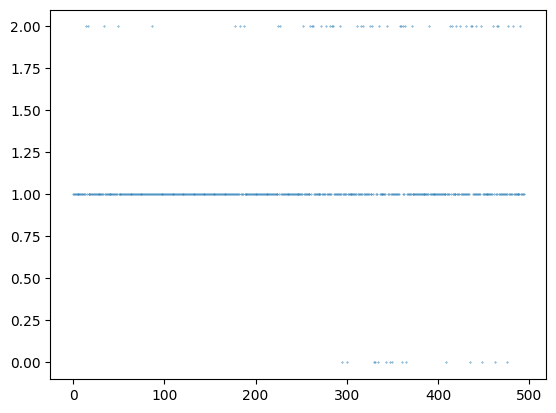

0
0
0
0
0
0
0
0
0
0
episode:40


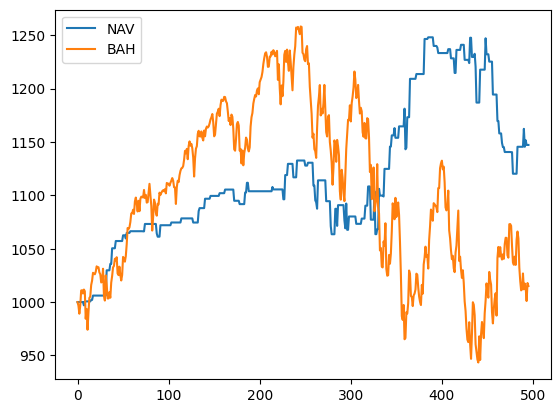

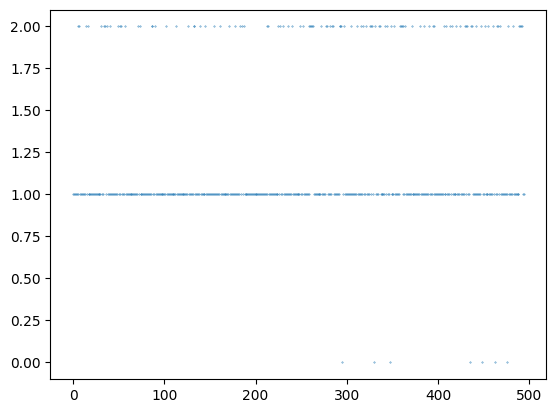

0
0
0
0
0
0
0
0
0
0
episode:50


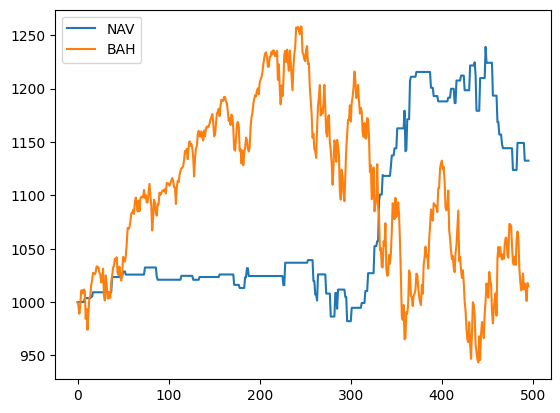

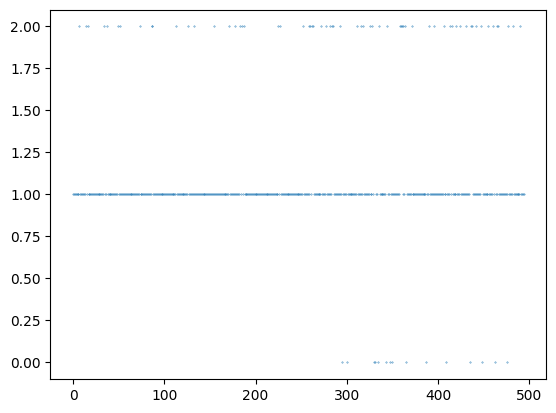

0
0
0
0
0
0
0
0
0
0
episode:60


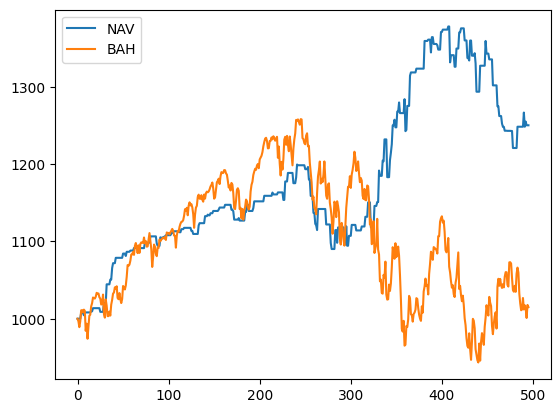

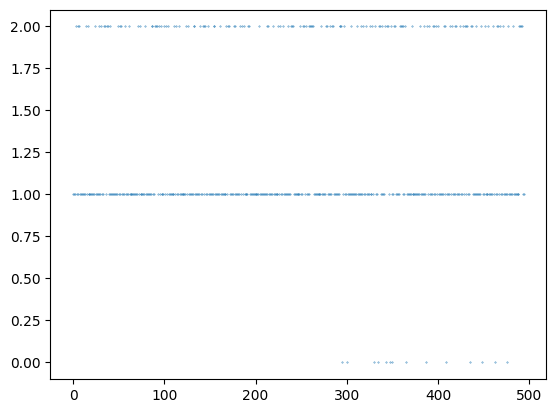

0
0
0
0
0
0
0
0
0
0
episode:70


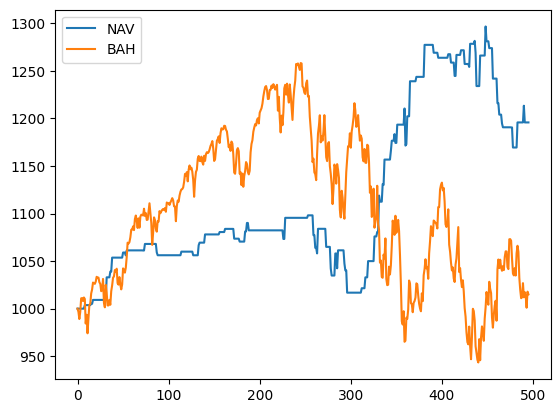

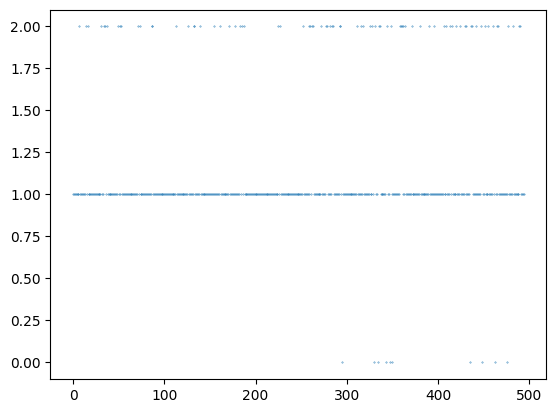

0
0
0
0
0
0
0
0
0
0
episode:80


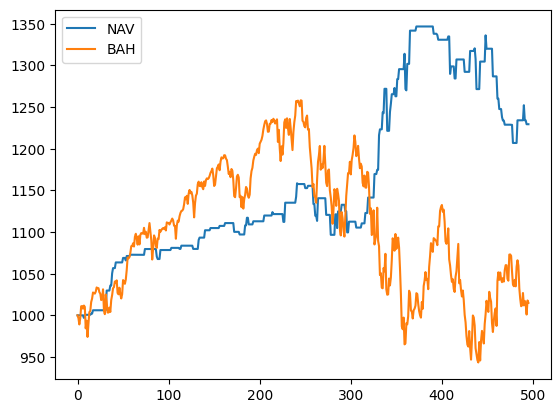

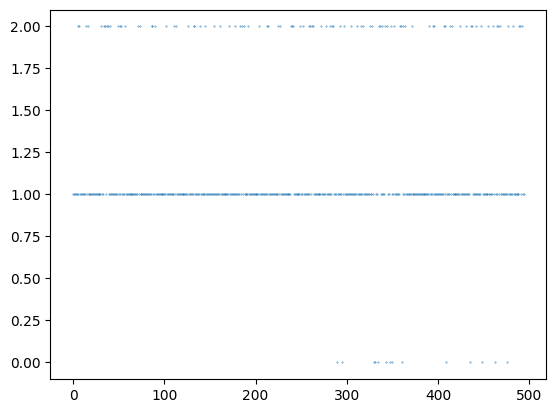

0
0
0
0
0
0
0
0
0
0
episode:90


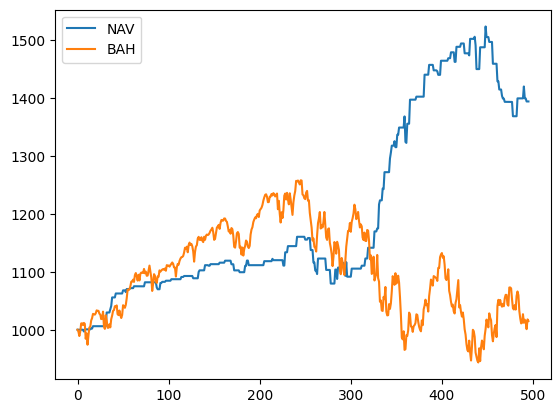

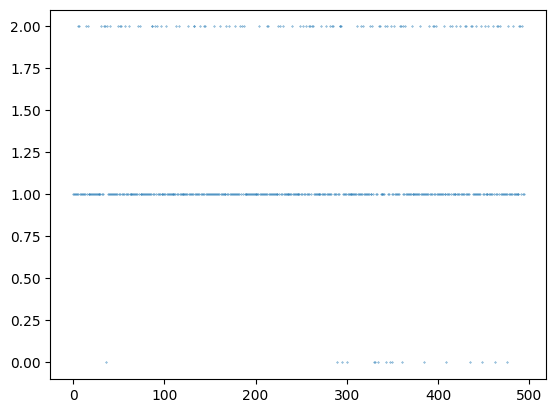

0
0
0
0
0
0
0
0
0


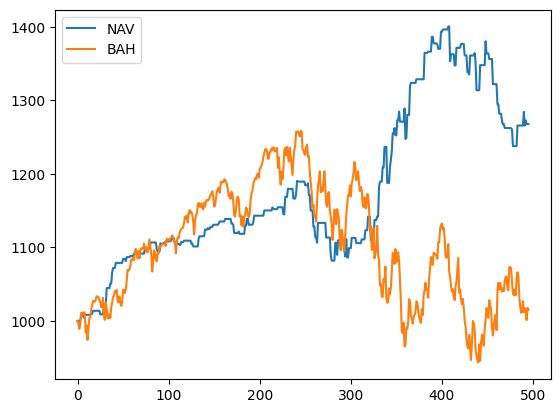

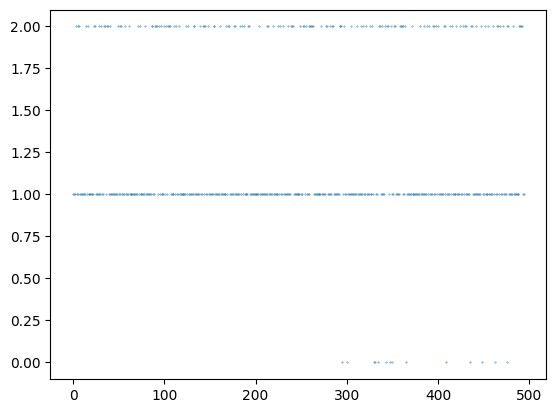

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.6.pth
current penalty factor:1.8
0
episode:0


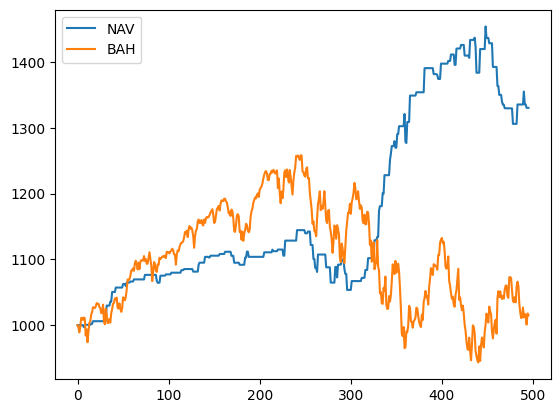

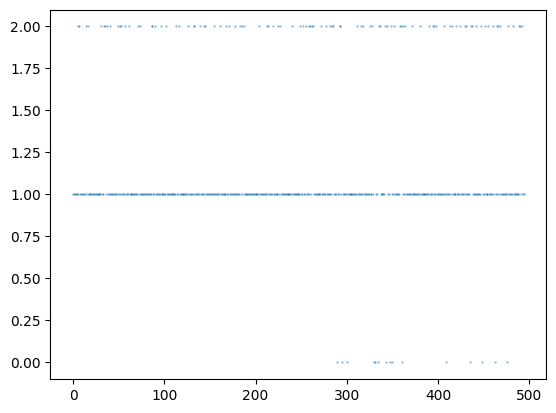

0
0
0
0
0
0
0
0
0
0
episode:10


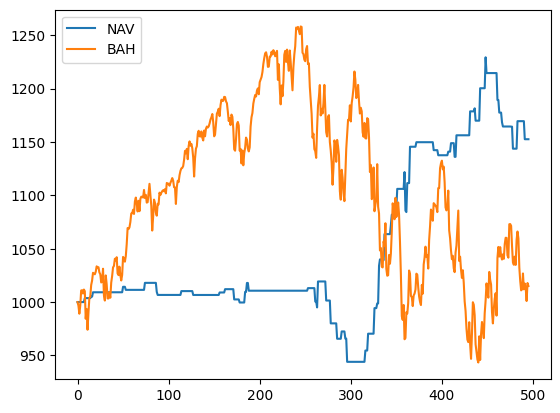

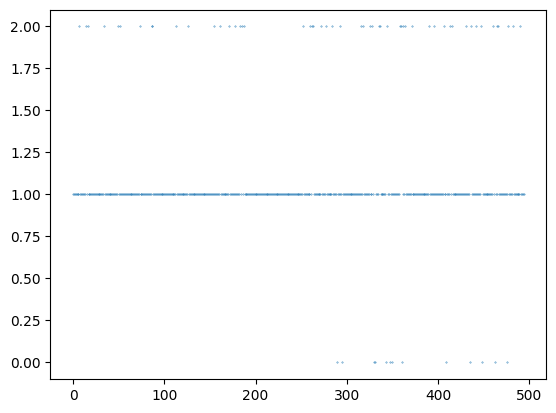

0
0
0
0
0
0
0
0
0
0
episode:20


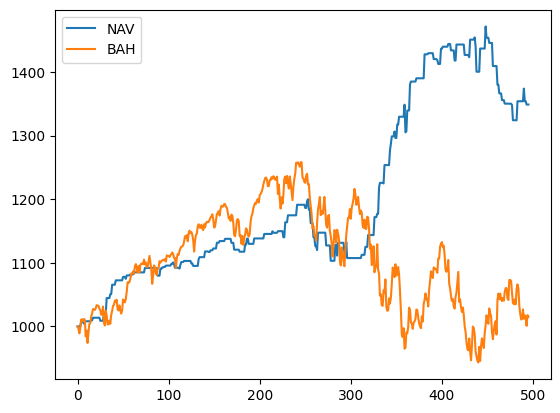

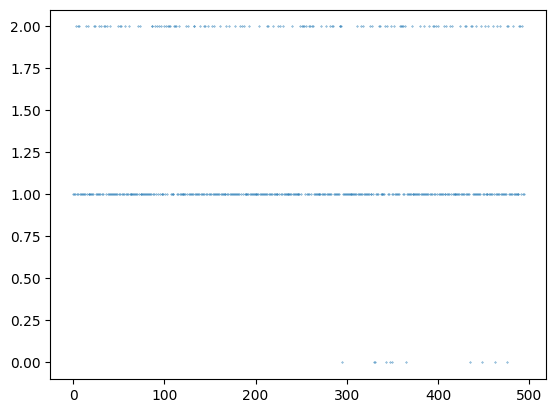

0
0
0
0
0
0
0
0
0
0
episode:30


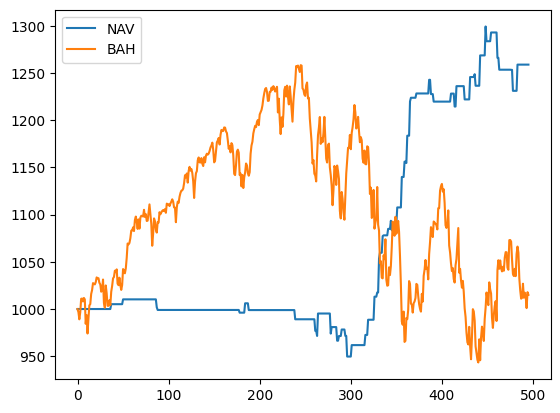

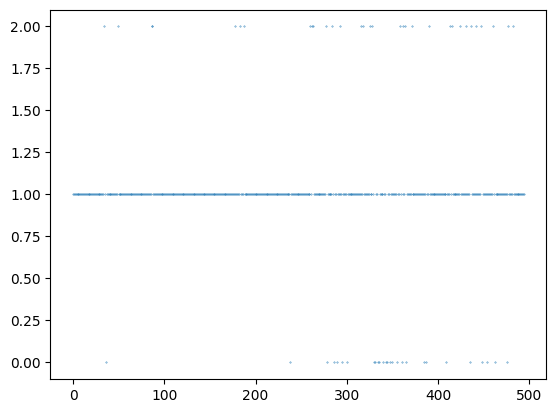

0
0
0
0
0
0
0
0
0
0
episode:40


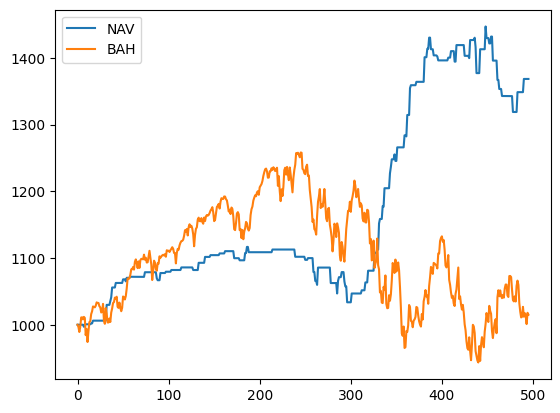

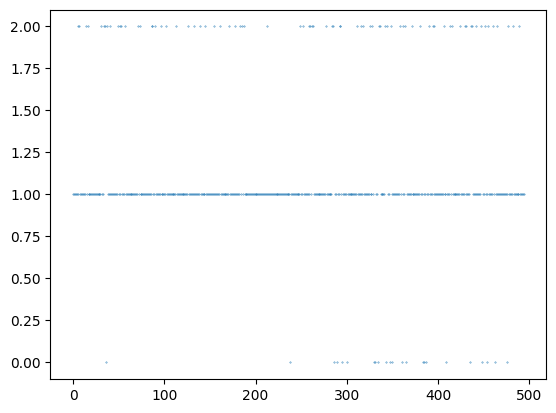

0
0
0
0
0
0
0
0
0
0
episode:50


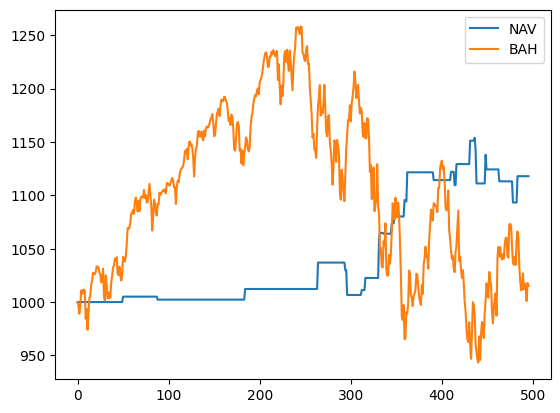

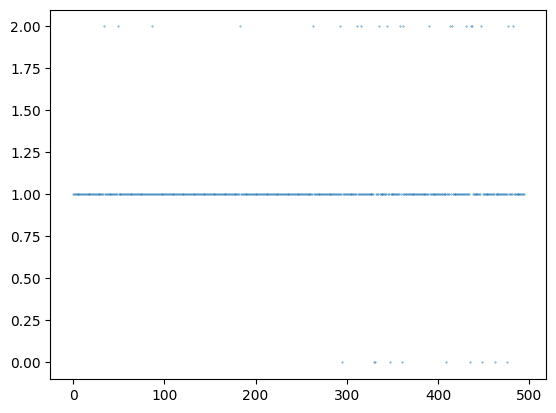

0
0
0
0
0
0
0
0
0
0
episode:60


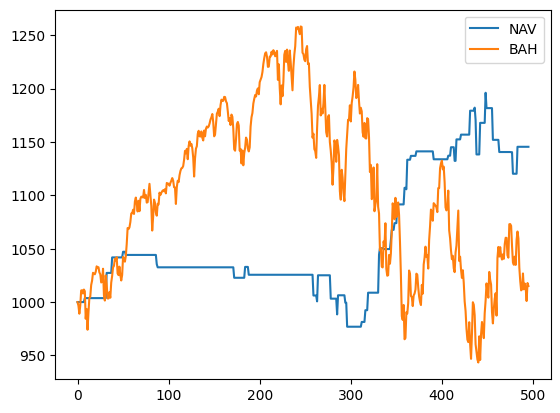

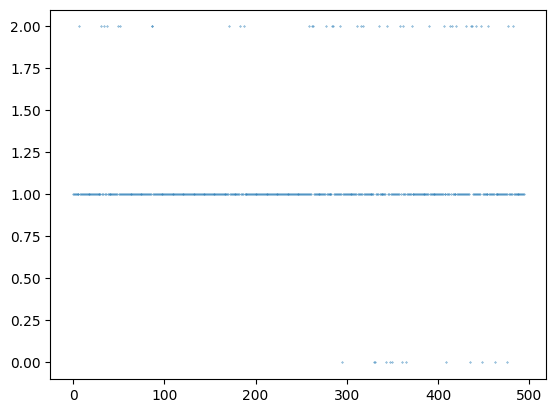

0
0
0
0
0
0
0
0
0
0
episode:70


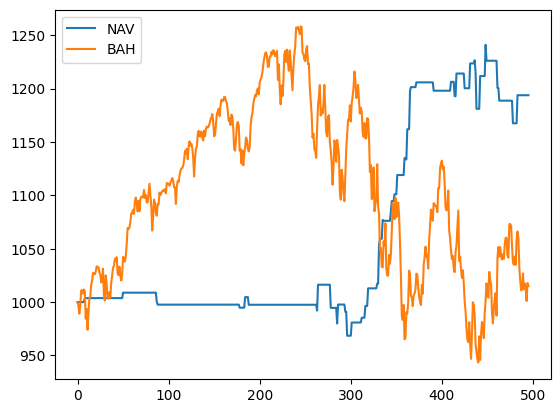

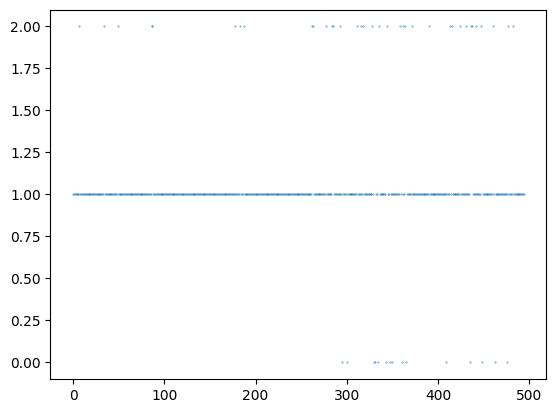

0
0
0
0
0
0
0
0
0
0
episode:80


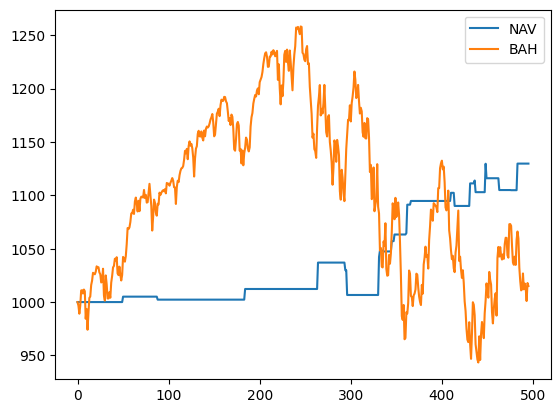

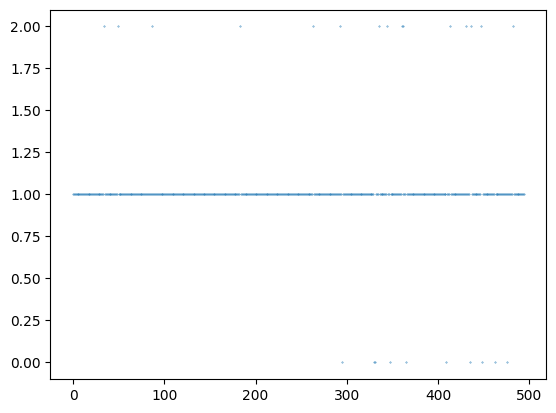

0
0
0
0
0
0
0
0
0
0
episode:90


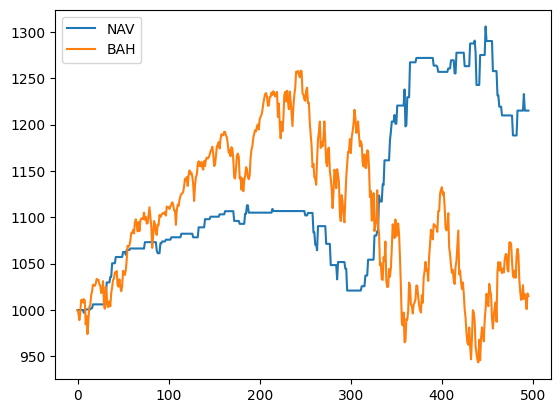

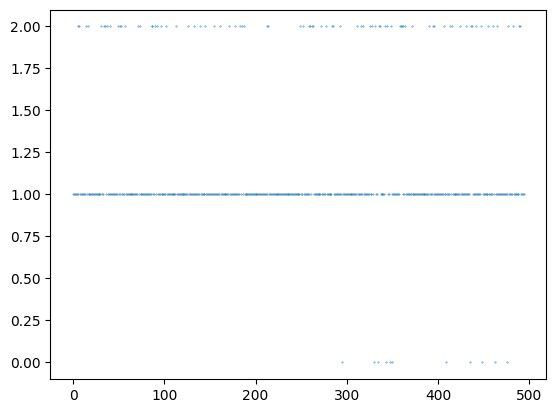

0
0
0
0
0
0
0
0
0


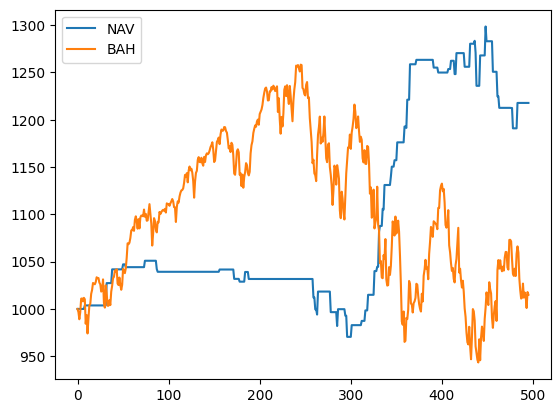

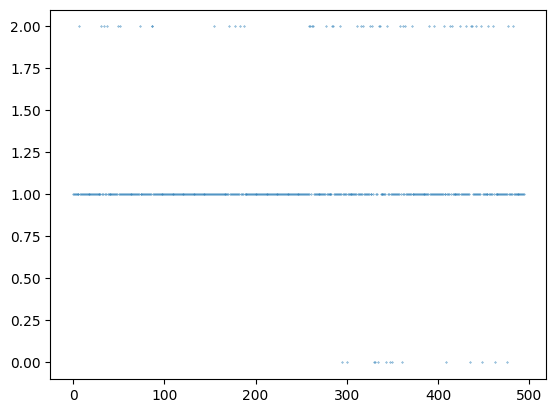

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_1.8.pth
current penalty factor:2.0
0
episode:0


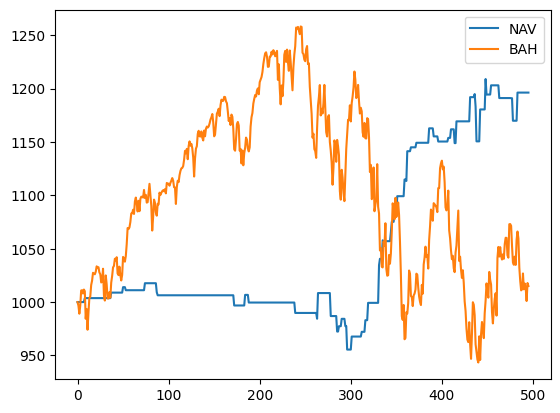

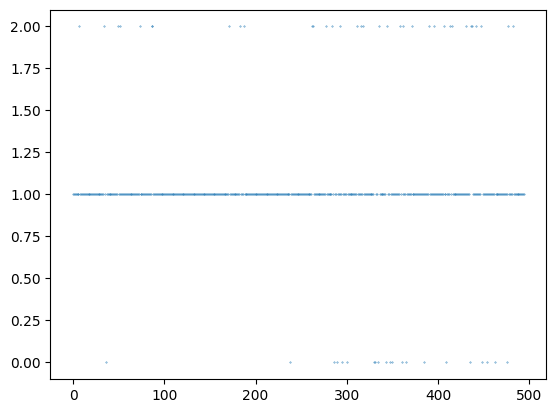

0
0
0
0
0
0
0
0
0
0
episode:10


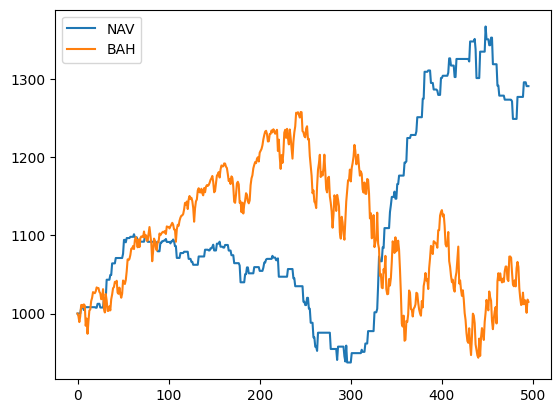

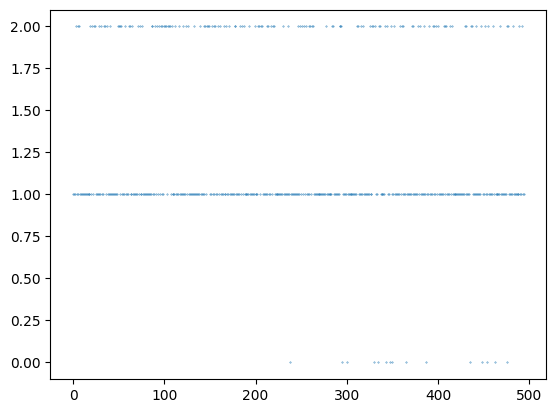

0
0
0
0
0
0
0
0
0
0
episode:20


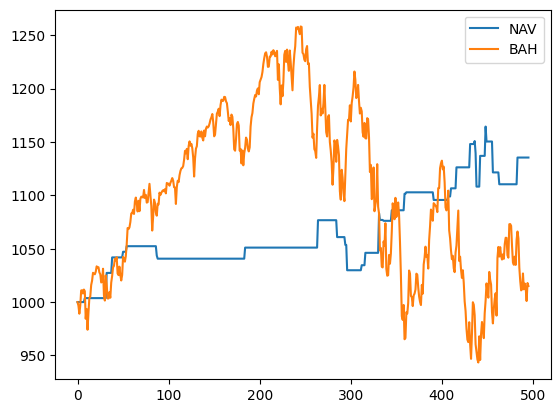

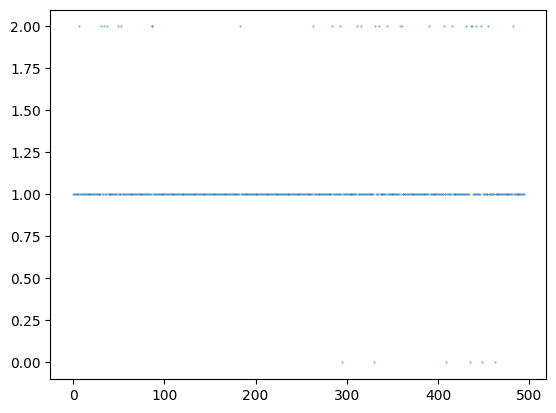

0
0
0
0
0
0
0
0
0
0
episode:30


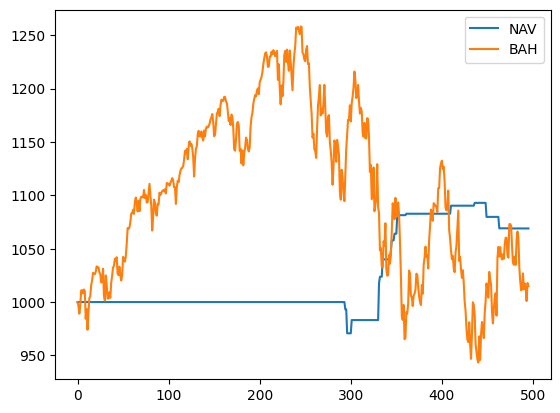

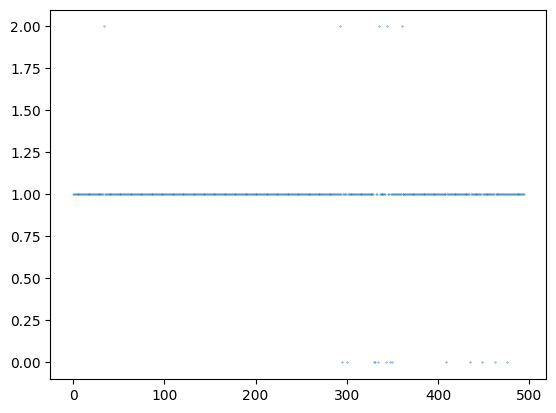

0
0
0
0
0
0
0
0
0
0
episode:40


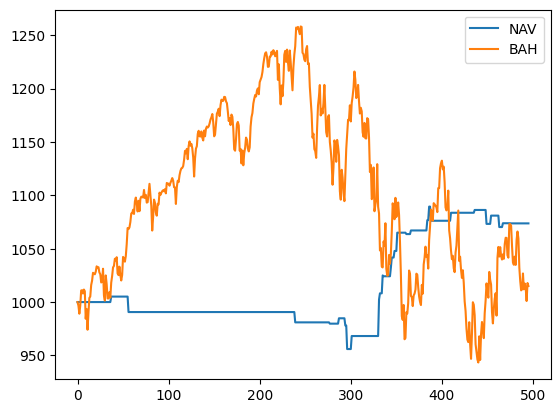

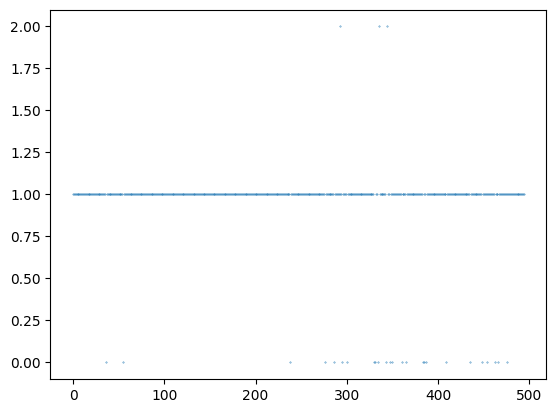

0
0
0
0
0
0
0
0
0
0
episode:50


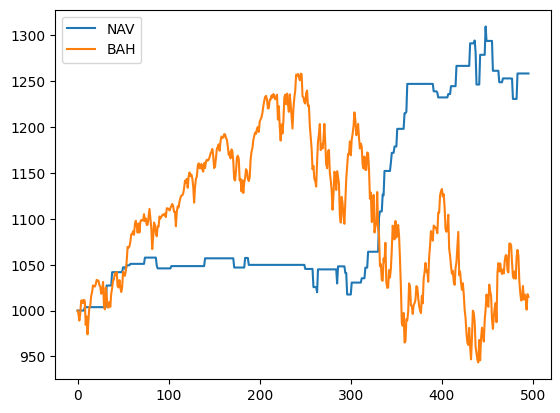

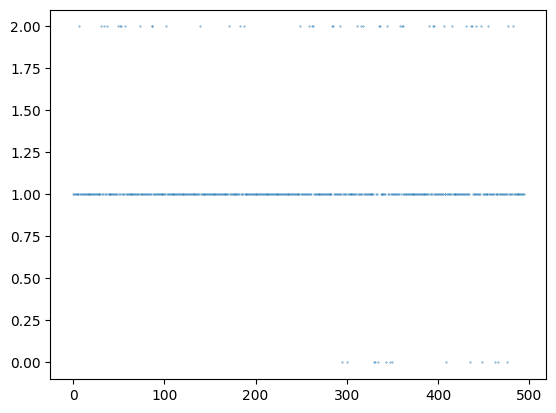

0
0
0
0
0
0
0
0
0
0
episode:60


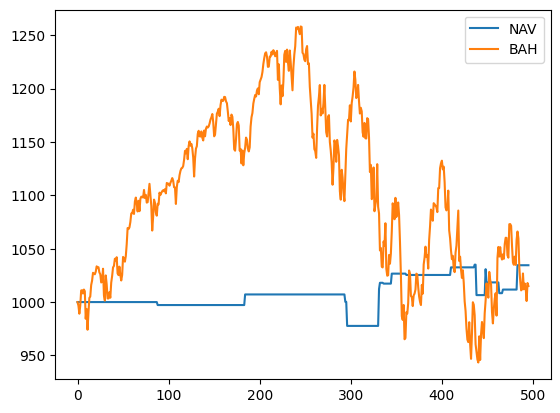

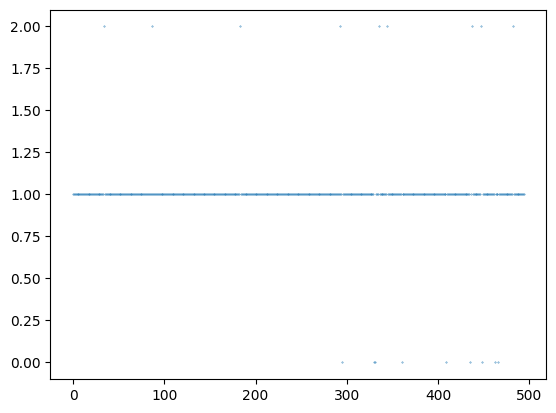

0
0
0
0
0
0
0
0
0
0
episode:70


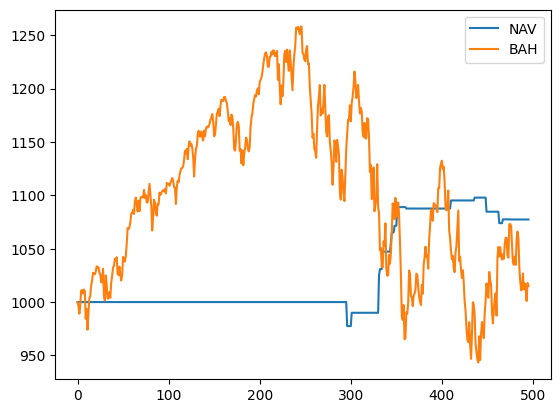

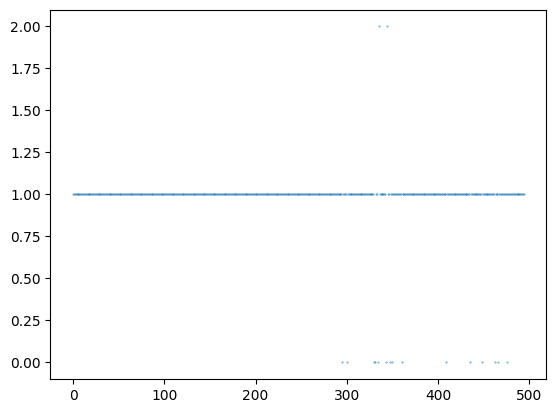

0
0
0
0
0
0
0
0
0
0
episode:80


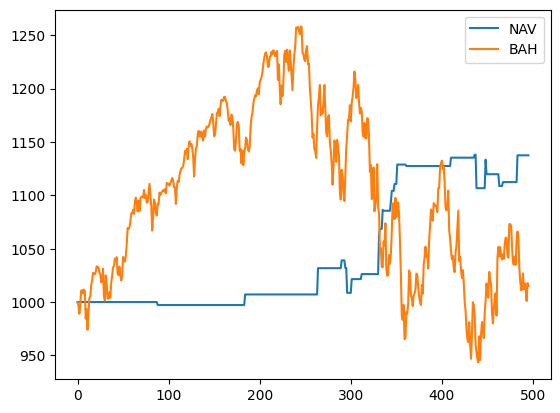

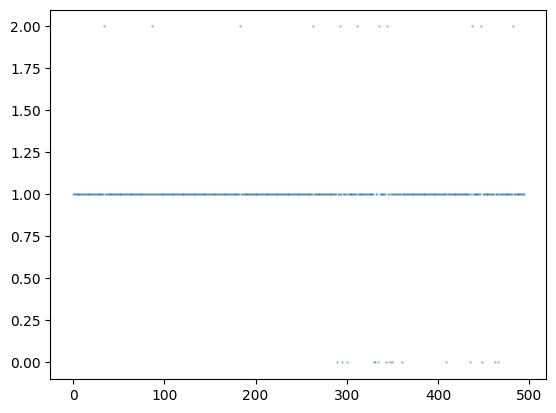

0
0
0
0
0
0
0
0
0
0
episode:90


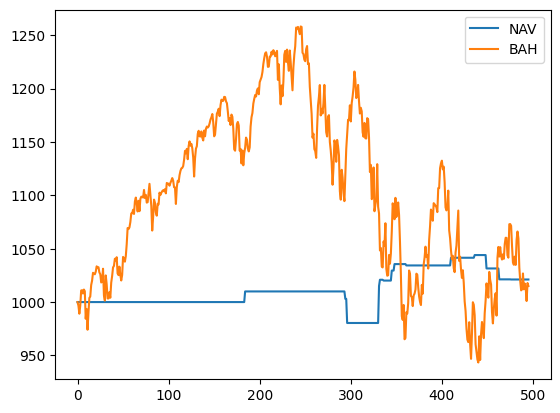

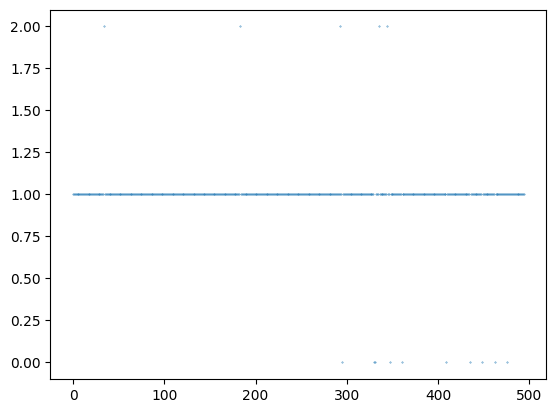

0
0
0
0
0
0
0
0
0


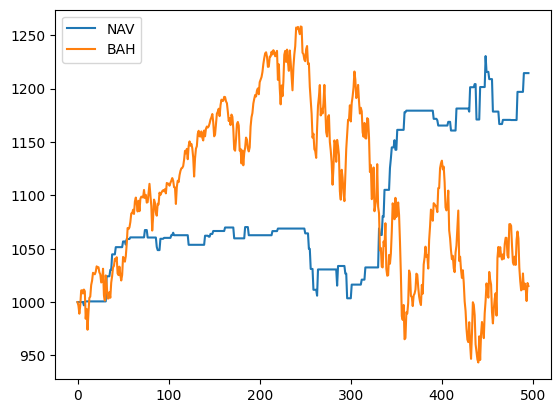

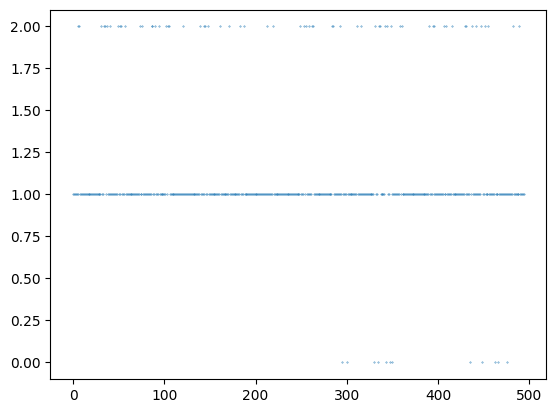

Model saved to: /content/drive/MyDrive/saved_models_nocost/target_model_2.0.pth


In [ ]:
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for penalty_factor in [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2.0]: #loop over the penalty factors that we want to test on
  print(f"current penalty factor:{penalty_factor}")
  for i_episode in range(num_episodes):

      # get 252 returns
      # since step start at 5, we extract 257 returns
      start = random.randint(0,len(data-500)-257)
      stock_returns = data.values[start:start + 257]

      #creat an env
      env = StockTradingEnv(stock_returns,TRANSCATION_COST,INIT_PORT)
      done = False
      #print(EPS)
      while not done:    
        #linear epsilon decay in the first n_exploration episodes, then exploit
        EPS = max(0,EPS-1/(252*N_EXPLORATION))
        
        state = env.current_state

        #get action
        action = select_action(state,EPS,env.action_space,policy_net,device)

        #step
        state, action,reward,next_state, done = env.step(action.item())

        #store in replay
        memory.push(torch.tensor(state.astype(np.float32),device=device), torch.tensor([action],device=device), torch.tensor(next_state.astype(np.float32),device=device), torch.tensor(reward,device=device))

        #optimize
        if len(memory) < 2:
            continue
        # if EPS > 0:
        #   optimize_model(memory,optimizer,policy_net,target_net,device,criterion,0,1)
        # else:
        optimize_model(memory,optimizer,policy_net,target_net,device,criterion,-0.01,penalty_factor)

        # Current Verision using soft update, the paper uses hard updates every 100 step
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
      if i_episode%10 == 0:
        print(f"episode:{i_episode}")
        eval_model(target_net)
  eval_model(target_net)
  #save target_model

  #change the path to corresponded folder for no-dueling or with-dueling or any other comparison purpose
  model_save_path = f"/content/drive/MyDrive/saved_models_nocost/target_model_{penalty_factor}.pth"
  torch.save(target_net.state_dict(), model_save_path)
  print(f"Model saved to: {os.path.abspath(model_save_path)}")


# Draw graphs

1.0


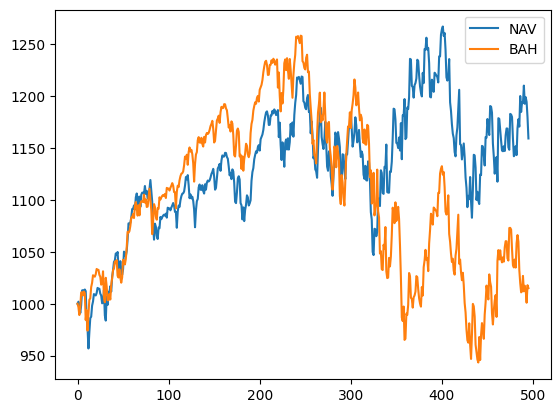

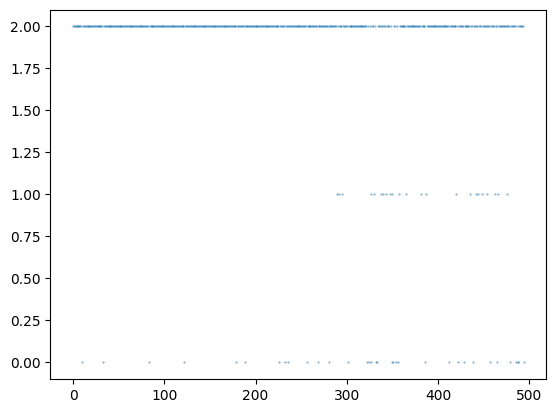

1.1


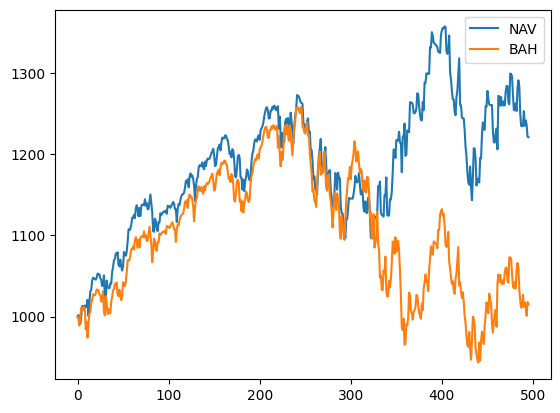

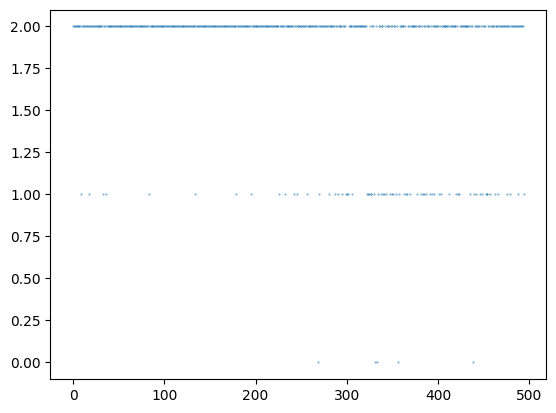

1.2


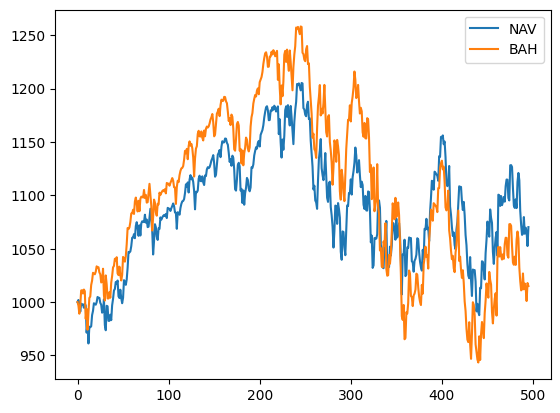

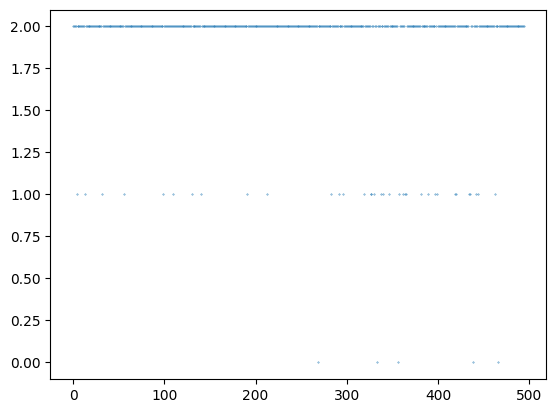

1.3


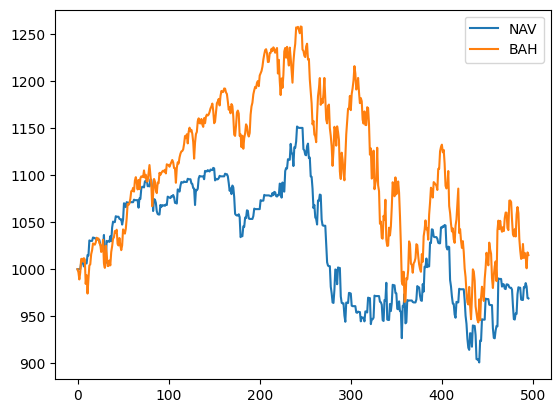

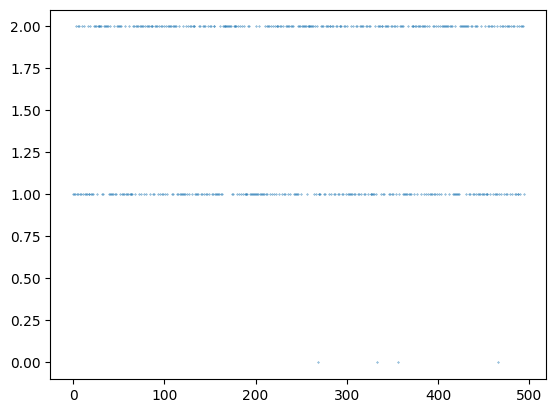

1.4


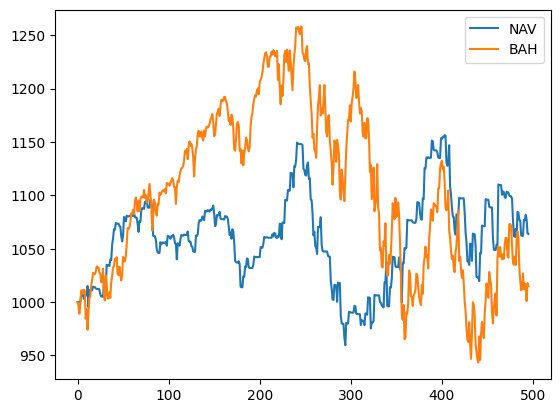

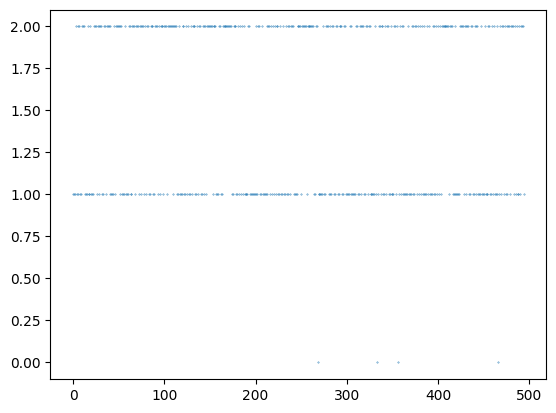

1.5


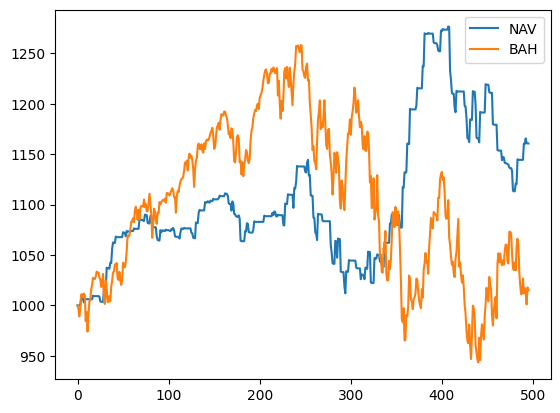

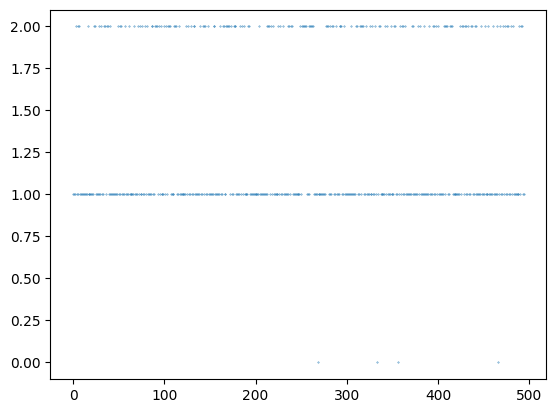

1.6


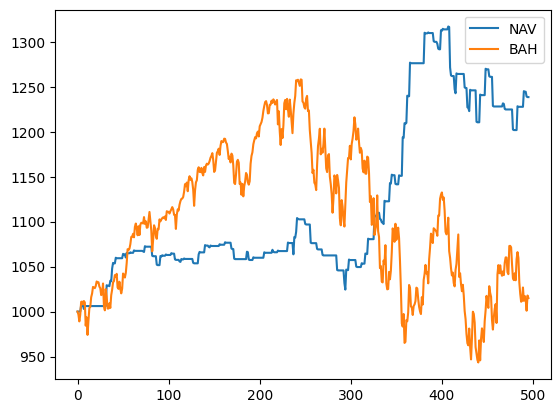

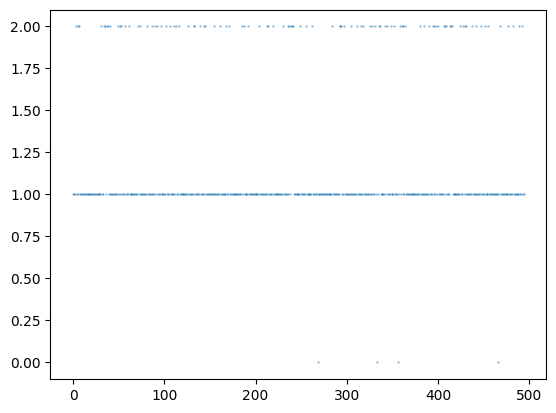

1.8


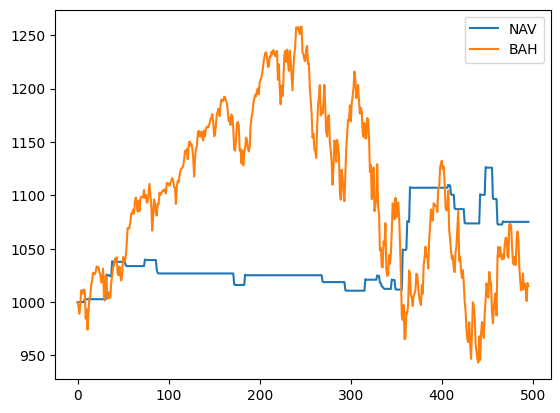

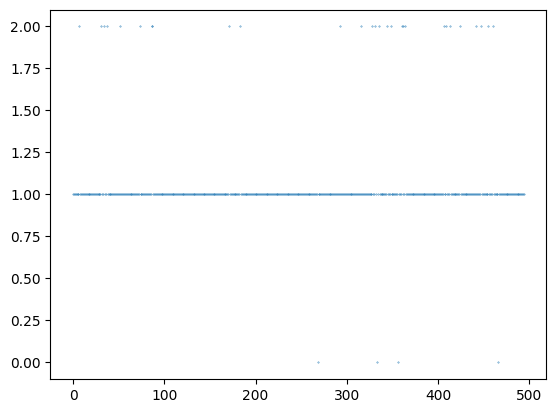

2.0


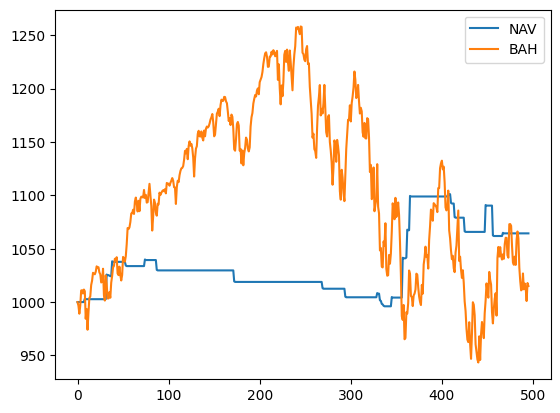

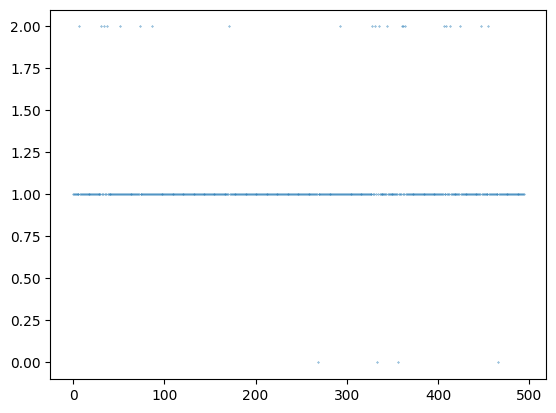

In [ ]:
# NO dueling
import os
folder_path = "/content/drive/MyDrive/saved_models_nd"

penalties_nd = {}
actions_dict_nd = {}

for filename in os.listdir(folder_path):
  if filename.endswith(".pth"):
    num_str = filename[:-4] #get rid of .pth from filename
    penalty_num = float(num_str.split("_")[2])

  # Load saved model
  saved_model_path = f"/content/drive/MyDrive/saved_models_nd/target_model_{penalty_num}.pth"
  saved_model = DQN(2, 3).to(device)
  saved_model.load_state_dict(torch.load(saved_model_path))
  print(penalty_num)

  penalties_nd[penalty_num], actions_dict_nd[penalty_num] = eval_model(saved_model)#get the portfolio and the actions they took for each penalty factor


for penalty_num, action_list in actions_dict_nd.items():
    actions_dict_nd[penalty_num] = [int(a.item()) for a in action_list]

# Evaluate saved model
#eval_model(saved_model)

2.0


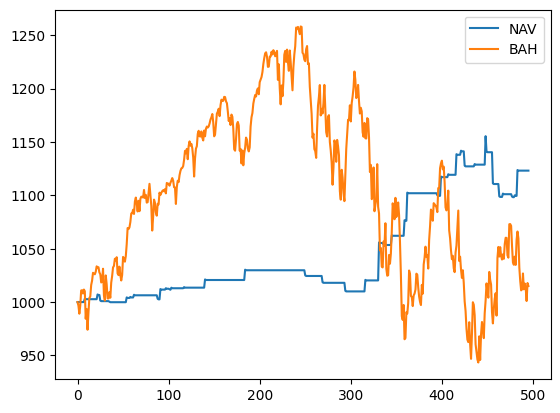

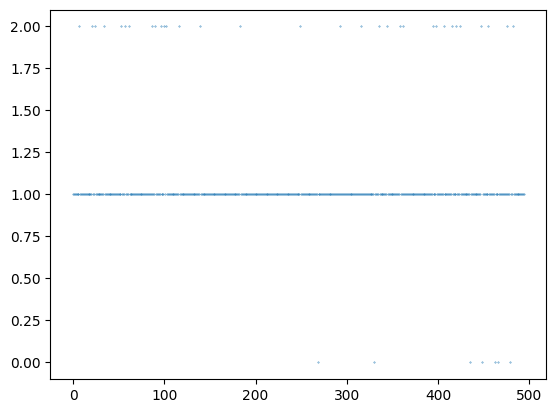

1.8


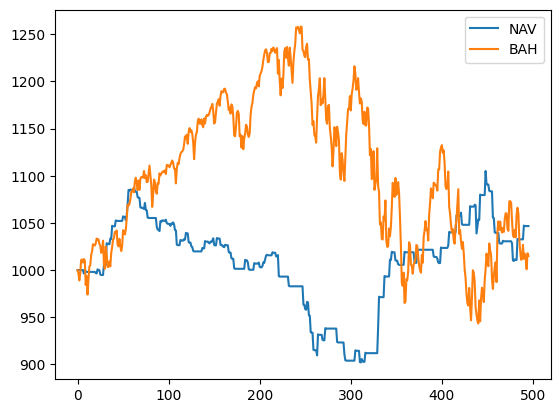

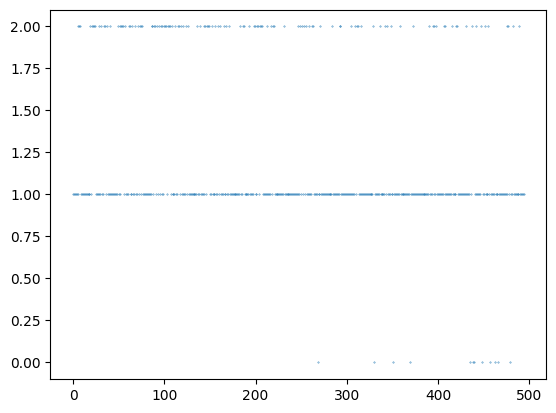

1.6


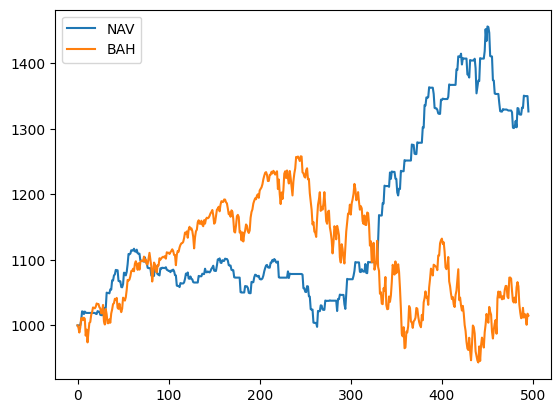

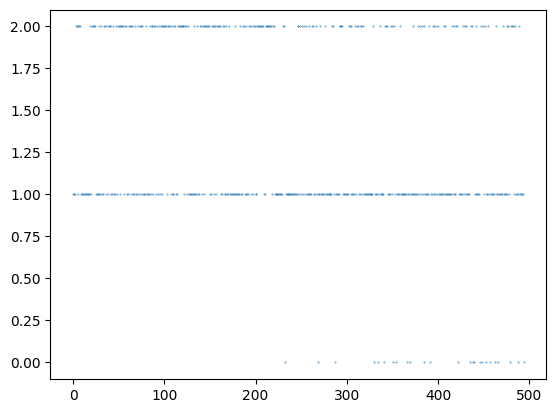

1.5


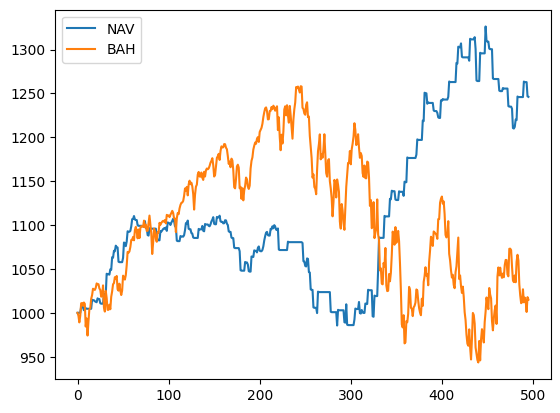

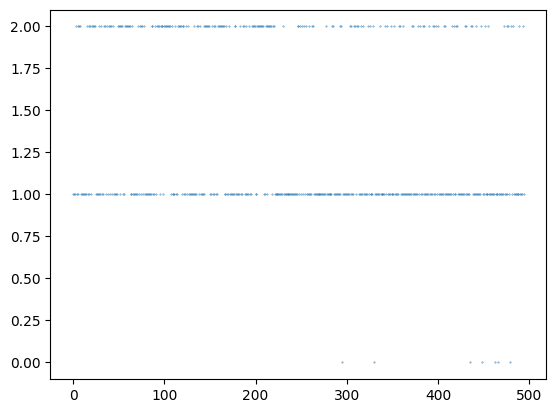

1.4


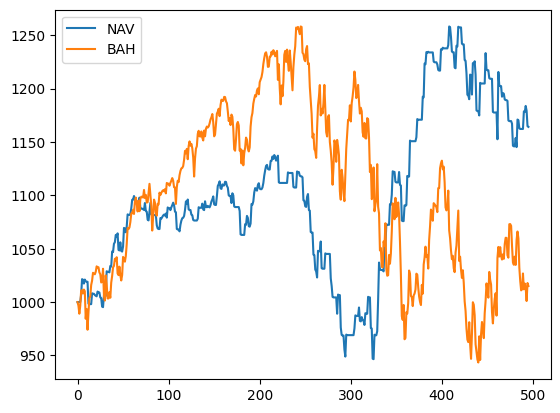

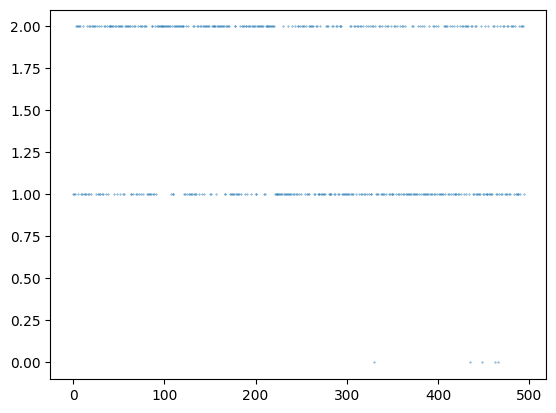

1.3


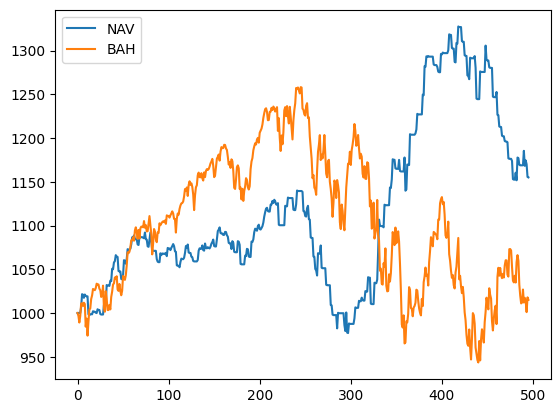

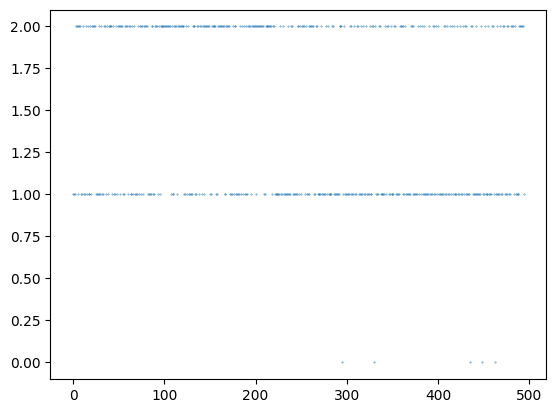

1.2


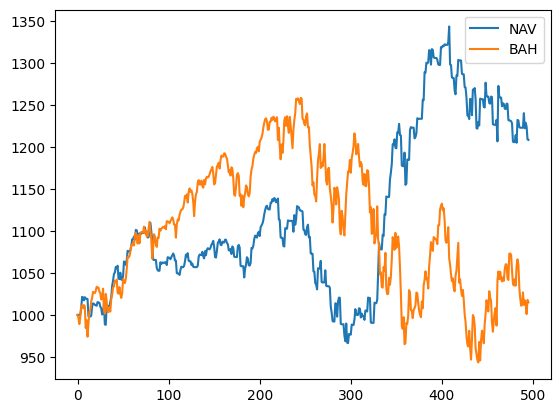

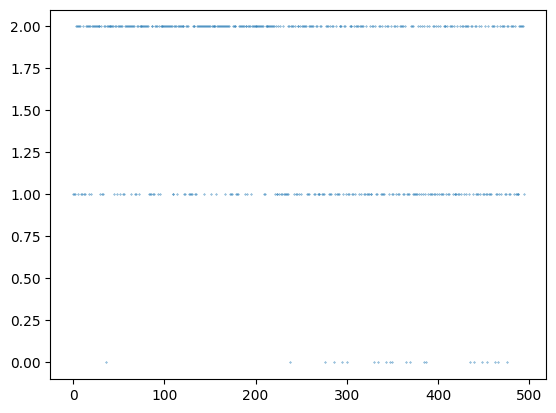

1.1


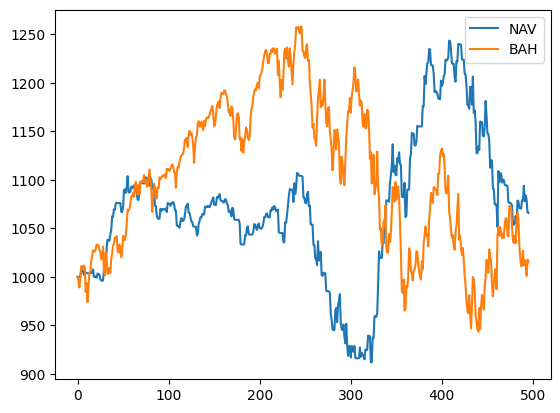

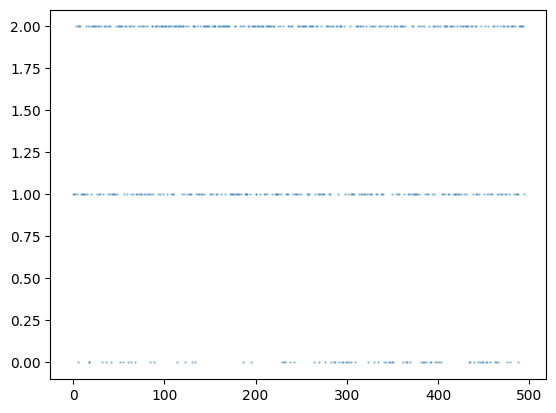

1.0


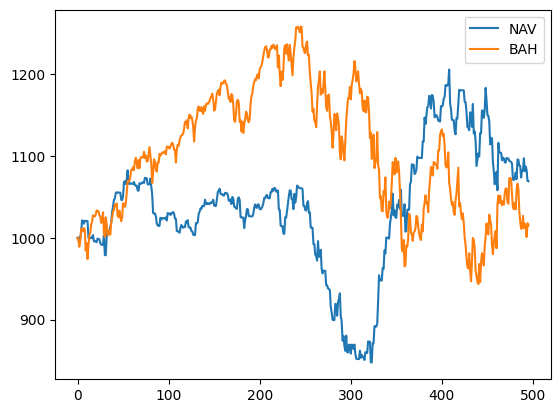

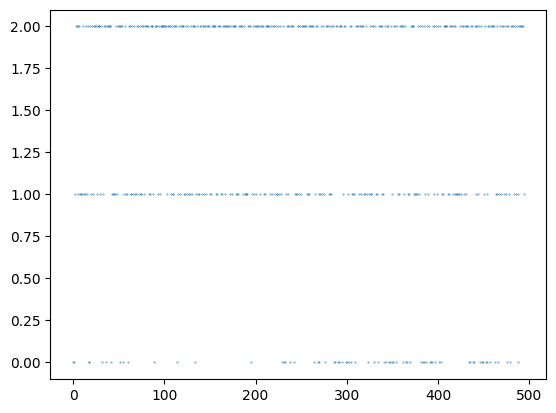

In [ ]:
#with dueling
import os
folder_path = "/content/drive/MyDrive/saved_models_wd"

penalties_wd = {}
actions_dict_wd = {}

for filename in os.listdir(folder_path):
  if filename.endswith(".pth"):
    num_str = filename[:-4] #get rid of .pth from filename
    penalty_num = float(num_str.split("_")[2])

  # Load saved model
  saved_model_path = f"/content/drive/MyDrive/saved_models_wd/target_model_{penalty_num}.pth"
  saved_model = DuelingDQN(2, 3).to(device)
  saved_model.load_state_dict(torch.load(saved_model_path))
  print(penalty_num)

  penalties_wd[penalty_num], actions_dict_wd[penalty_num] = eval_model(saved_model)#get the portfolio and the actions they took for each penalty factor


for penalty_num, action_list in actions_dict_wd.items():
    actions_dict_wd[penalty_num] = [int(a.item()) for a in action_list]

In [ ]:
#print(len(penalties_nd))
#print(len(penalties_wd))

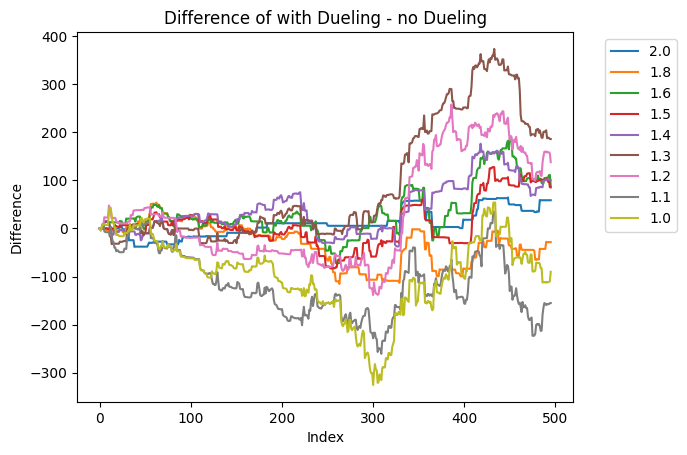

In [ ]:
#compare No-deuling and with-dueling
import matplotlib.pyplot as plt
import numpy as np

# Convert the lists in the dictionaries to NumPy arrays
penalties_wd = {k: np.array(v) for k, v in penalties_wd.items()}
penalties_nd = {k: np.array(v) for k, v in penalties_nd.items()}

for key in penalties_wd.keys():
    # Calculate the difference between the arrays for each key
    diff = penalties_wd[key] - penalties_nd[key]

    # Plot the difference as a line graph
    plt.plot(diff, label=key)

# Add labels and legend to the plot
plt.xlabel("Index")
plt.ylabel("Difference")
plt.title("Difference of with Dueling - no Dueling")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()

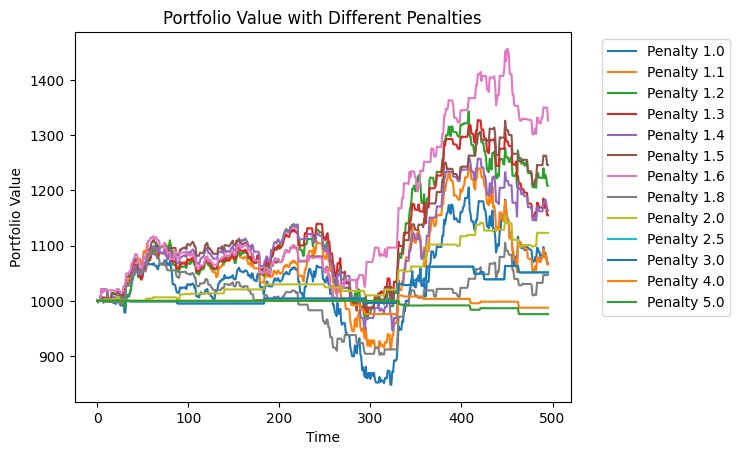

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#plot out the portfolio change for each penalty factor with dueling
for penalty, values in penalties_wd.items():
    plt.plot(values, label=f"Penalty {penalty}")

plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value with Different Penalties")

plt.show(dpi=300)

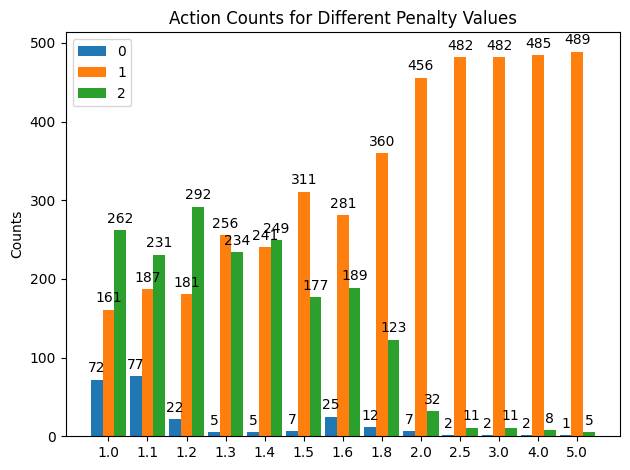

In [ ]:
'''
this part is to count how many of each action type is performed for each penalty factor
'''
action_counts = {}
sorted_actions = dict(sorted(actions_dict_wd.items(), key=lambda x: x[0]))
for penalty_value, actions_list in sorted_actions.items():
    action_counts[penalty_value] = [actions_list.count(0), actions_list.count(1), actions_list.count(2)]

# Set up the grouped bar chart
labels = list(action_counts.keys())
zeros, ones, twos = zip(*action_counts.values())
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, zeros, width, label='0')
rects2 = ax.bar(x, ones, width, label='1')
rects3 = ax.bar(x + width, twos, width, label='2')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Counts')
ax.set_title('Action Counts for Different Penalty Values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to auto-label the bars with their heights
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()